# Проект по оптимизации процессов работы интернет магазина.

## Цели исследования :

- Создание новых признаков на основании полученных данных.

- Разработка модели для интернет магазина с целью выявления пользователей планирующих совершить покупку в течении 90 дней.

## Ход исследования :

- Загрузка и изучение поступивших данных.

- Поиск и обработка дефектов в данных.

- Создание релевантных признаков , для последующей передачи на обучение моделей.

- Обучение и оценка эффективности по метрике *ROC-AUC*.

- Финальный вывод и рекомендации.

## Описание переменных представленных в данных


**Датасеты**
- **apparel-purchases** :  
  - `client_id` - идентификатор пользователя  
  - `quantity` - количество товаров в заказе
  - `price` -  цена товара
  - `category_ids` -   вложенные категории, к которым относится товар
  - `date` - дата покупки
  - `message_id` - идентификатор сообщения из рассылки
- **apparel-messages** :  
  - `bulk_campaign_id` - идентификатор рекламной кампании 
  - `client_id` -  идентификатор пользователя
  - `message_id` - идентификатор сообщений
  - `event`  - тип действия
  - `channel` - канал рассылки
  - `date` - дата рассылки
  - `created_at` - точное время создания сообщения
- **apparel-target_binary** :  
  - `RegistrationYear`  
  - `Power`  
- **full_campaign_daily_event_channel** :
  - `date` - дата
  - `bulk_campaign_id` - идентификатор рассылки
  - `count_event_channel` - общее количество каждого события по каналам
  - `nunique_event_channel` - количество уникальных client_id по событиям и каналам



## Технический модуль.

### Импорт библиотек.

In [9]:
RS = 42
%matplotlib inline 

In [123]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shap
import phik
import warnings
import time
import joblib
import math
import ast
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ydata_profiling import ProfileReport
from datetime import datetime, timedelta
from lightgbm import LGBMRegressor
from category_encoders import CatBoostEncoder
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from category_encoders import TargetEncoder
from sklearn.metrics import (r2_score, 
                             mean_squared_error, 
                             mean_absolute_error, 
                             accuracy_score, precision_score,
                             recall_score, 
                             confusion_matrix, 
                             precision_recall_curve, 
                             classification_report, 
                             roc_auc_score, 
                             make_scorer, 
                             f1_score)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Импорт функций.

## Загрузка и первичное ознакомление с данными.

#### **apparel-messages.csv**

In [11]:
df_mess = pd.read_csv('apparel-messages.csv')

In [12]:
display(df_mess.info())
display(df_mess.describe().T)
display(df_mess.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

count          mean           std           min  \
bulk_campaign_id  12739798.0  1.160459e+04  3.259211e+03  5.480000e+02   
client_id         12739798.0  1.515916e+18  1.329704e+08  1.515916e+18   

                           25%           50%           75%           max  
bulk_campaign_id  8.746000e+03  1.351600e+04  1.415800e+04  1.465700e+04  
client_id         1.515916e+18  1.515916e+18  1.515916e+18  1.515916e+18

bulk_campaign_id            client_id  \
0              4439  1515915625626736623   
1              4439  1515915625490086521   
2              4439  1515915625553578558   
3              4439  1515915625553578558   
4              4439  1515915625471518311   
5              4439  1515915625594606468   
6              4439  1515915625491810918   
7              4439  1515915625474219766   
8              4439  1515915625474219766   
9              4439  1515915625566741491   

                               message_id  event channel        date  \
0  1515915625626736623-4439-6283415ac07ea   open   email  2022-05-19   
1  1515915625490086521-4439-62834150016dd   open   email  2022-05-19   
2  1515915625553578558-4439-6283415b36b4f   open   email  2022-05-19   
3  1515915625553578558-4439-6283415b36b4f  click   email  2022-05-19   
4  1515915625471518311-4439-628341570c133   open   email  2022-05-19   
5  1515915625594606468-4439-6283411f277fc   open   email  2022-05-19   
6  1515915625491810918-4439-6283411d9d299   open   email  2022-05-19   
7  1515915625474219766-4439-628341212233a   open   email  2022-05-19   
8  1515915625474219766-4439-628341212233a  click   email  2022-05-19   
9  1515915625566741491-4439-6283412871599   open   email  2022-05-19   

            created_at  
0  2022-05-19 00:14:20  
1  2022-05-19 00:39:34  
2  2022-05-19 00:51:49  
3  2022-05-19 00:52:20  
4  2022-05-19 00:56:52  
5  2022-05-19 01:04:11  
6  2022-05-19 01:19:54  
7  2022-05-19 01:23:43  
8  2022-05-19 01:24:16  
9  2022-05-19 01:31:06

In [13]:
df_mess['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

In [14]:
#ProfileReport(df_mess, title="Profiling Report", minimal=False, progress_bar=False)

### **apparel-purchases.csv**

In [15]:
df_purch = pd.read_csv('apparel-purchases.csv')

In [16]:
display(df_purch.info())
display(df_purch.describe().T)
display(df_purch.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

count          mean           std           min           25%  \
client_id  202208.0  1.515916e+18  1.459458e+08  1.515916e+18  1.515916e+18   
quantity   202208.0  1.006483e+00  1.843837e-01  1.000000e+00  1.000000e+00   
price      202208.0  1.193302e+03  1.342253e+03  1.000000e+00  3.520000e+02   

                    50%           75%           max  
client_id  1.515916e+18  1.515916e+18  1.515916e+18  
quantity   1.000000e+00  1.000000e+00  3.000000e+01  
price      9.870000e+02  1.699000e+03  8.549900e+04

client_id  quantity   price                     category_ids  \
0  1515915625468169594         1  1999.0         ['4', '28', '57', '431']   
1  1515915625468169594         1  2499.0         ['4', '28', '57', '431']   
2  1515915625471138230         1  6499.0         ['4', '28', '57', '431']   
3  1515915625471138230         1  4999.0        ['4', '28', '244', '432']   
4  1515915625471138230         1  4999.0         ['4', '28', '49', '413']   
5  1515915625471640575         1  3499.0        ['2', '18', '258', '441']   
6  1515915625490211585         1  1699.0       ['2', '18', '341', '1311']   
7  1515915625490739153         1  1999.0        ['2', '18', '123', '451']   
8  1515915625491478747         1   999.0  ['5562', '5631', '5549', '667']   
9  1515915625491651493         1   699.0  ['5562', '5630', '5649', '678']   

         date                              message_id  
0  2022-05-16  1515915625468169594-4301-627b661e9736d  
1  2022-05-16  1515915625468169594-4301-627b661e9736d  
2  2022-05-16  1515915625471138230-4437-6282242f27843  
3  2022-05-16  1515915625471138230-4437-6282242f27843  
4  2022-05-16  1515915625471138230-4437-6282242f27843  
5  2022-05-16  1515915625471640575-4301-627b661b67ac3  
6  2022-05-16  1515915625490211585-4301-627b661843283  
7  2022-05-16  1515915625490739153-4172-626b943cc789b  
8  2022-05-16  1515915625491478747-4273-6274ceb769d59  
9  2022-05-16  1515915625491651493-4437-6282242f2a9e2

In [17]:
ProfileReport(df_purch, title="Profiling Report", minimal=False, progress_bar=False)

100%|██████████| 6/6 [00:00<00:00,  9.12it/s]


### **target.csv**

In [18]:
df_target = pd.read_csv('apparel-target_binary.csv')

In [19]:
display(df_target.info())
display(df_target.describe().T)
display(df_target.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

count          mean           std           min           25%  \
client_id  49849.0  1.515916e+18  1.487947e+08  1.515916e+18  1.515916e+18   
target     49849.0  1.927822e-02  1.375025e-01  0.000000e+00  0.000000e+00   

                    50%           75%           max  
client_id  1.515916e+18  1.515916e+18  1.515916e+18  
target     0.000000e+00  0.000000e+00  1.000000e+00

client_id  target
0  1515915625468060902       0
1  1515915625468061003       1
2  1515915625468061099       0
3  1515915625468061100       0
4  1515915625468061170       0
5  1515915625468061514       0
6  1515915625468061877       0
7  1515915625468061975       0
8  1515915625468061994       0
9  1515915625468062158       0

In [20]:
df_target['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

### **full_campaign_daily_event_channel.csv**

In [21]:
df_event_channel = pd.read_csv('full_campaign_daily_event_channel.csv')

In [22]:
display(df_event_channel.info())
display(df_event_channel.describe().T)
display(df_event_channel.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

None

count         mean            std    min  \
bulk_campaign_id                 131072.0  8416.743378    4877.369306  548.0   
count_click_email                131072.0    41.582169     745.484035    0.0   
count_click_mobile_push          131072.0    49.400803    1036.952898    0.0   
count_open_email                 131072.0   423.706032    9753.383722    0.0   
count_open_mobile_push           131072.0  3347.384659   64448.590783    0.0   
count_purchase_email             131072.0     0.357483       8.287483    0.0   
count_purchase_mobile_push       131072.0     0.220444       3.796500    0.0   
count_soft_bounce_email          131072.0    24.474823     727.069387    0.0   
count_subscribe_email            131072.0     0.140518       2.072777    0.0   
count_unsubscribe_email          131072.0     6.362679      79.172069    0.0   
nunique_click_email              131072.0    31.396263     562.883309    0.0   
nunique_click_mobile_push        131072.0    42.879753     833.316257    0.0   
nunique_open_email               131072.0   411.661484    9519.712509    0.0   
nunique_open_mobile_push         131072.0  3271.338539   61880.005289    0.0   
nunique_purchase_email           131072.0     0.287712       6.484979    0.0   
nunique_purchase_mobile_push     131072.0     0.177391       2.971908    0.0   
nunique_soft_bounce_email        131072.0    24.262146     724.270910    0.0   
nunique_subscribe_email          131072.0     0.134125       1.976439    0.0   
nunique_unsubscribe_email        131072.0     5.960602      73.284148    0.0   
count_hard_bounce_mobile_push    131072.0    59.483444    1371.955350    0.0   
count_send_mobile_push           131072.0  7444.561638  139350.920933    0.0   
nunique_hard_bounce_mobile_push  131072.0    58.863007    1357.271261    0.0   
nunique_send_mobile_push         131072.0  7350.266907  135579.922072    0.0   
count_hard_bounce_email          131072.0    18.989990    1402.414107    0.0   
count_hbq_spam_email             131072.0     0.810364     183.298579    0.0   
count_send_email                 131072.0  4189.580681  107319.764245    0.0   
nunique_hard_bounce_email        131072.0    18.535683    1349.473695    0.0   
nunique_hbq_spam_email           131072.0     0.809799     183.298245    0.0   
nunique_send_email               131072.0  4186.897934  107261.800074    0.0   
count_soft_bounce_mobile_push    131072.0     3.332489     120.916269    0.0   
nunique_soft_bounce_mobile_push  131072.0     3.311653     120.094858    0.0   
count_complain_email             131072.0     0.932655      30.198326    0.0   
nunique_complain_email           131072.0     0.921326      29.715170    0.0   
count_close_mobile_push          131072.0     0.000008       0.002762    0.0   
nunique_close_mobile_push        131072.0     0.000008       0.002762    0.0   

                                    25%     50%      75%         max  
bulk_campaign_id                 4116.0  7477.0  13732.0     15150.0  
count_click_email                   0.0     0.0      1.0     59365.0  
count_click_mobile_push             0.0     0.0      0.0    128453.0  
count_open_email                    1.0     5.0     23.0   2597015.0  
count_open_mobile_push              0.0     0.0      0.0   5076151.0  
count_purchase_email                0.0     0.0      0.0      1077.0  
count_purchase_mobile_push          0.0     0.0      0.0       431.0  
count_soft_bounce_email             0.0     0.0      0.0     76284.0  
count_subscribe_email               0.0     0.0      0.0       189.0  
count_unsubscribe_email             0.0     0.0      1.0      9089.0  
nunique_click_email                 0.0     0.0      1.0     45718.0  
nunique_click_mobile_push           0.0     0.0      0.0     75899.0  
nunique_open_email                  1.0     5.0     23.0   2548617.0  
nunique_open_mobile_push            0.0     0.0      0.0   2922440.0  
nunique_purchase_email              0.0     0.0      0.0       779.0  
nunique_purchase_mo

date  bulk_campaign_id  count_click_email  count_click_mobile_push  \
0  2022-05-19               563                  0                        0   
1  2022-05-19               577                  0                        0   
2  2022-05-19               622                  0                        0   
3  2022-05-19               634                  0                        0   
4  2022-05-19               676                  0                        0   
5  2022-05-19               764                  0                        0   
6  2022-05-19               766                  0                        0   
7  2022-05-19               783                  1                        0   
8  2022-05-19               817                  0                        0   
9  2022-05-19               833                  0                        0   

   count_open_email  count_open_mobile_push  count_purchase_email  \
0                 4                       0                     0   
1                 1                       0                     0   
2                 2                       0                     0   
3                 1                       0                     0   
4                 1                       0                     0   
5                 2                       0                     0   
6                 2                       0                     0   
7                 8                       0                     0   
8                 2                       0                     0   
9                 1                       0                     0   

   count_purchase_mobile_push  count_soft_bounce_email  count_subscribe_email  \
0                           0                        0                      0   
1                           0                        0                      0   
2                           0                        0                      0   
3                           0                        0                      0   
4                           0                        0                      0   
5                           0                        0                      0   
6                           0                        0                      0   
7                           0                        0                      0   
8                           0                        0                      0   
9                           0                        0                      0   

   ...  count_send_email  nunique_hard_bounce_email  nunique_hbq_spam_email  \
0  ...                 0                          0                       0   
1  ...                 0                          0                       0   
2  ...                 0                          0                       0   
3  ...                 0                          0                       0   
4  ...                 0                          0                       0   
5  ...                 0                          0                       0   
6  ...                 0                          0                       0   
7  ...                 0                          0                       0   
8  ...                 0                          0                       0   
9  ...                 0                          0                       0   

   nunique_send_email  count_soft_bounce_mobile_push  \
0                   0                              0   
1                   0                              0   
2                   0                              0   
3                   0                              0   
4                   0                              0   
5                   0                              0   
6                   0                              0   
7                   0                              0   
8                   0                              0   
9                   0                              0   



### **full_campaign_daily_event.csv**

In [23]:
df_event = pd.read_csv('full_campaign_daily_event.csv')

In [24]:
display(df_event.info())
display(df_event.describe().T)
display(df_event.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

None

count          mean            std    min     25%  \
bulk_campaign_id     131072.0   8416.743378    4877.369306  548.0  4116.0   
count_click          131072.0     90.982971    1275.503564    0.0     0.0   
count_complain       131072.0      0.932655      30.198326    0.0     0.0   
count_hard_bounce    131072.0     78.473434    1961.317826    0.0     0.0   
count_open           131072.0   3771.090691   65160.668444    0.0     1.0   
count_purchase       131072.0      0.577927       9.107040    0.0     0.0   
count_send           131072.0  11634.142319  175709.508290    0.0     0.0   
count_soft_bounce    131072.0     27.807312     736.944714    0.0     0.0   
count_subscribe      131072.0      0.140518       2.072777    0.0     0.0   
count_unsubscribe    131072.0      6.362679      79.172069    0.0     0.0   
nunique_click        131072.0     74.276016    1004.271405    0.0     0.0   
nunique_complain     131072.0      0.921326      29.715170    0.0     0.0   
nunique_hard_bounce  131072.0     77.398689    1913.395511    0.0     0.0   
nunique_open         131072.0   3683.000023   62586.472916    0.0     1.0   
nunique_purchase     131072.0      0.465103       7.126368    0.0     0.0   
nunique_send         131072.0  11537.164841  172700.489055    0.0     0.0   
nunique_soft_bounce  131072.0     27.573799     734.050700    0.0     0.0   
nunique_subscribe    131072.0      0.134125       1.976439    0.0     0.0   
nunique_unsubscribe  131072.0      5.960602      73.284148    0.0     0.0   
count_hbq_spam       131072.0      0.810364     183.298579    0.0     0.0   
nunique_hbq_spam     131072.0      0.809799     183.298245    0.0     0.0   
count_close          131072.0      0.000008       0.002762    0.0     0.0   
nunique_close        131072.0      0.000008       0.002762    0.0     0.0   

                        50%      75%         max  
bulk_campaign_id     7477.0  13732.0     15150.0  
count_click             0.0      2.0    128453.0  
count_complain          0.0      0.0      5160.0  
count_hard_bounce       0.0      0.0    287404.0  
count_open              6.0     30.0   5076151.0  
count_purchase          0.0      0.0      1077.0  
count_send              0.0      0.0  11543513.0  
count_soft_bounce       0.0      0.0     76284.0  
count_subscribe         0.0      0.0       189.0  
count_unsubscribe       0.0      1.0      9089.0  
nunique_click           0.0      1.0     75899.0  
nunique_complain        0.0      0.0      5043.0  
nunique_hard_bounce     0.0      0.0    287341.0  
nunique_open            6.0     30.0   2922440.0  
nunique_purchase        0.0      0.0       779.0  
nunique_send            0.0      0.0   7094600.0  
nunique_soft_bounce     0.0      0.0     76281.0  
nunique_subscribe       0.0      0.0       177.0  
nunique_unsubscribe     0.0      1.0      8299.0  
count_hbq_spam          0.0      0.0     63920.0  
nunique_hbq_spam        0.0      0.0     63920.0  
count_close             0.0      0.0         1.0  
nunique_close           0.0      0.0         1.0

date  bulk_campaign_id  count_click  count_complain  \
0  2022-05-19               563            0               0   
1  2022-05-19               577            0               0   
2  2022-05-19               622            0               0   
3  2022-05-19               634            0               0   
4  2022-05-19               676            0               0   
5  2022-05-19               764            0               0   
6  2022-05-19               766            0               0   
7  2022-05-19               783            1               0   
8  2022-05-19               817            0               0   
9  2022-05-19               833            0               0   

   count_hard_bounce  count_open  count_purchase  count_send  \
0                  0           4               0           0   
1                  0           1               0           0   
2                  0           2               0           0   
3                  0           1               0           0   
4                  0           1               0           0   
5                  0           2               0           0   
6                  0           2               0           0   
7                  0           8               0           0   
8                  0           2               0           0   
9                  0           1               0           0   

   count_soft_bounce  count_subscribe  ...  nunique_open  nunique_purchase  \
0                  0                0  ...             4                 0   
1                  0                0  ...             1                 0   
2                  0                0  ...             2                 0   
3                  0                0  ...             1                 0   
4                  0                0  ...             1                 0   
5                  0                0  ...             2                 0   
6                  0                0  ...             2                 0   
7                  0                0  ...             6                 0   
8                  0                0  ...             2                 0   
9                  0                0  ...             1                 0   

   nunique_send  nunique_soft_bounce  nunique_subscribe  nunique_unsubscribe  \
0             0                    0                  0                    0   
1             0                    0                  0                    0   
2             0                    0                  0                    0   
3             0                    0                  0                    0   
4             0                    0                  0                    0   
5             0                    0                  0                    0   
6             0                    0                  0                    0   
7             0                    0                  0                    0   
8             0                    0                  0                    0   
9             0                    0                  0                    0   

   count_hbq_spam  nunique_hbq_spam  count_close  nunique_close  
0               0                 0            0              0  
1               0                 0            0              0  
2               0                 0            0              0  
3               0                 0            0              0  
4               0                 0            0              0  
5               0                 0            0              0  
6               0                 0            0              0  
7               0                 0            0              0  
8               0                 0            0              0  
9               0                 0            0              0  

[10 rows x 24 columns]

### Вывод

- Мы загрузили полученные нами датасеты , каких либо сильных аномалий в данных не обнаружено.

- Во всех датафреймах присутствует столбец *client_id* , именно по нему мы и будет выполнять дальнейшую агрегацию и объединение наших данных.

## Предобработка данных

### Проверка на дубликаты и анализ соответствия датафреймов.

Проверим все ли значения **client_id** совпадают в наших датафреймах , выполнив проверку по df_target

In [25]:
df_target['client_id'].isin(df_purch['client_id']).all()

True

Видим полное соответствие датасетов *df_target* и *df_purch* по *client_id*.

In [26]:
df_target['client_id'].isin(df_mess['client_id']).all()

False

In [27]:
df_target[~df_target['client_id'].isin(df_mess['client_id'])]

client_id  target
293    1515915625468081882       0
347    1515915625468087979       0
418    1515915625468093885       1
564    1515915625468105189       0
777    1515915625468122963       0
...                    ...     ...
49843  1515915626010256069       0
49845  1515915626010266132       0
49846  1515915626010439406       0
49847  1515915626010443527       0
49848  1515915626010443624       0

[7867 rows x 2 columns]

Видим что в *df_target* 7867 значений уникальных клиентов , по которым в *df_mess* нет информации.

Это создаст проблемы на этапе создания признаков из *df_mess*.

**При первичном рассмотрении данных , нами были обнаружены явные дубликаты , рассмотрим их подробней.**

#### df_purch

In [28]:
check_purch = df_purch.copy()

In [29]:
df_purch.duplicated().sum()

73020

In [30]:
print(f'Процентное соотношение дубликатов в датафрейме : {df_purch.duplicated().sum() / len(df_purch)*100:.2f}%')

Процентное соотношение дубликатов в датафрейме : 36.11%


In [31]:
df_purch[df_purch.duplicated(keep=False)]

client_id  quantity   price  \
11      1515915625491869271         2   599.0   
12      1515915625491869271         2   599.0   
21      1515915625566606509         1   299.0   
22      1515915625566606509         1   299.0   
41      1515915625468070175         1  2199.0   
...                     ...       ...     ...   
202201  1515915626010261344         1  1499.0   
202202  1515915626010261344         1  1499.0   
202203  1515915626010261344         1  1499.0   
202204  1515915626010439406         1    99.0   
202205  1515915626010439406         1    99.0   

                           category_ids        date  \
11           ['4', '27', '350', '1392']  2022-05-16   
12           ['4', '27', '350', '1392']  2022-05-16   
21      ['5562', '5634', '5579', '710']  2022-05-16   
22      ['5562', '5634', '5579', '710']  2022-05-16   
41            ['4', '27', '142', '496']  2022-05-17   
...                                 ...         ...   
202201        ['2', '18', '212', '726']  2024-02-16   
202202        ['2', '18', '212', '726']  2024-02-16   
202203        ['2', '18', '212', '726']  2024-02-16   
202204        ['4', '27', '233', '462']  2024-02-16   
202205        ['4', '27', '233', '462']  2024-02-16   

                                     message_id  
11       1515915625491869271-2090-61a72488d6a0f  
12       1515915625491869271-2090-61a72488d6a0f  
21       1515915625566606509-4301-627b66245401d  
22       1515915625566606509-4301-627b66245401d  
41       1515915625468070175-4439-6283414668daa  
...                                         ...  
202201  1515915626010261344-14648-65cdb6d56c4c8  
202202  1515915626010261344-14648-65cdb6d56c4c8  
202203  1515915626010261344-14648-65cdb6d56c4c8  
202204  1515915625776605028-14662-65cf3abfe4f0d  
202205  1515915625776605028-14662-65cf3abfe4f0d  

[131683 rows x 6 columns]

Так как , у нас нет более подробной временной метки содержащей точное время , сделаем предположение что это повторные заказы или идентичные товары из одного чека.

Поэтому оставим данные в неизменном виде.

#### df_mess

In [32]:
df_mess.duplicated().sum()

48610

In [33]:
print(f'Процентное соотношение дубликатов в датафрейме : {df_mess.duplicated().sum() / len(df_mess)*100:.2f}%')

Процентное соотношение дубликатов в датафрейме : 0.38%


In [34]:
df_mess[df_mess.duplicated(keep=False)]

bulk_campaign_id            client_id  \
964231                5723  1515915625554535987   
964232                5723  1515915625554535987   
966465                5723  1515915625483569932   
966466                5723  1515915625483569932   
967281                5723  1515915625736038297   
...                    ...                  ...   
12739720             14600  1515915625468103375   
12739721             14607  1515915625468103375   
12739722             14607  1515915625468103375   
12739730             14623  1515915625559065669   
12739731             14623  1515915625559065669   

                                       message_id  event      channel  \
964231     1515915625554535987-5723-62e2af08e00da  click  mobile_push   
964232     1515915625554535987-5723-62e2af08e00da  click  mobile_push   
966465     1515915625483569932-5723-62e2af0790ad5  click  mobile_push   
966466     1515915625483569932-5723-62e2af0790ad5  click  mobile_push   
967281     1515915625736038297-5723-62e2af0a17cba  click  mobile_push   
...                                           ...    ...          ...   
12739720  1515915625468103375-14600-65c2038646d16  click  mobile_push   
12739721  1515915625468103375-14607-65c33b1f402bb  click  mobile_push   
12739722  1515915625468103375-14607-65c33b1f402bb  click  mobile_push   
12739730  1515915625559065669-14623-65c5c5df06b3b  click  mobile_push   
12739731  1515915625559065669-14623-65c5c5df06b3b  click  mobile_push   

                date           created_at  
964231    2022-07-28  2022-07-28 15:58:56  
964232    2022-07-28  2022-07-28 15:58:56  
966465    2022-07-28  2022-07-28 16:07:12  
966466    2022-07-28  2022-07-28 16:07:12  
967281    2022-07-28  2022-07-28 16:09:56  
...              ...                  ...  
12739720  2024-02-15  2024-02-15 21:52:00  
12739721  2024-02-15  2024-02-15 21:52:00  
12739722  2024-02-15  2024-02-15 21:52:00  
12739730  2024-02-15  2024-02-15 22:02:19  
12739731  2024-02-15  2024-02-15 22:02:19  

[94519 rows x 7 columns]

Видим что в дублирующих строках , время отправки полностью совпадает до секунды , в действительности такое маловероятно.

Ввиду подозрительного совпадения времени и малой размерности , примем решении об удалении подозрительных значений из датафрейма с сохранением первого вхождения.

In [35]:
check_mess = df_mess.copy()
df_mess.drop_duplicates(keep='first', inplace=True)
print(f'Размерность датафрейма до изменения : {len(check_mess)}')
print(f'Размерность датафрейма  после удаления дубликатов : {len(df_mess)}')

Размерность датафрейма до изменения : 12739798
Размерность датафрейма  после удаления дубликатов : 12691188


#### df_target

In [36]:
df_target.duplicated().sum()

0

В датасете с целевой переменной , дубликатов не обнаружено.

#### Вывод

- Мы провели проверке на дубликаты и обнаружили в датасете df_purch 73020 кол-во дубликатов , что составило 36.11% от общего числа представленных данных. Мы решили оставить все без изменений , так как не смогли найти достаточно веских доводов для удаления.

- В датафрейме df_mess так же были обнаружены идентичные строки в кол-ве 48610 , что составило примерно (0.4%) от всего набора данных. В этом случе фактов для удаления дубликатов было достаточно , что мы и сделали , повысив чистоту входных данных.

- В наборе данных с целевой переменной df_target , повторов обнаружить не удалось.

### Обработка и создание признаков.

#### df_purch

##### date

Преобразуем столбец с датой в подходящий формат для дальнейшего удобства извлечения данных.

In [37]:
df_purch['date'] = df_purch['date'].apply(pd.to_datetime)

In [38]:
df_purch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


Посмотрим на года за которые за которые у нас представленны данные.

In [39]:
df_purch['date'].dt.year.value_counts()

date
2023    109680
2022     81621
2024     10907
Name: count, dtype: int64

Используем эту информацию для создания признака покупок по годам для каждого уникального пользователя.

In [40]:
check_purch['year'] = df_purch['date'].dt.year

In [41]:
years = check_purch.pivot_table(index='client_id', columns="year", values='quantity', aggfunc='size', fill_value=0)
years.head(10)

year                 2022  2023  2024
client_id                            
1515915625468060902     7     0     0
1515915625468061003     0     7     0
1515915625468061099     1     0     0
1515915625468061100     0     0     2
1515915625468061170     0    19     0
1515915625468061514     1     0     0
1515915625468061877     1     0     0
1515915625468061975     1     0     0
1515915625468061994     8     0     0
1515915625468062158     2     2     0

##### total_quantity

Так же создадим агрегацию по уникальным пользователя , содержащую информацию об общем кол-ве покупок.

In [42]:
total_quan = df_purch.pivot_table(index='client_id', values="quantity",aggfunc='count')
total_quan.head(10)

quantity
client_id                    
1515915625468060902         7
1515915625468061003         7
1515915625468061099         1
1515915625468061100         2
1515915625468061170        19
1515915625468061514         1
1515915625468061877         1
1515915625468061975         1
1515915625468061994         8
1515915625468062158         4

##### total_price

По аналогии с предыдущими шагами сделаем тоже самое для общей суммы всех покупок.

In [43]:
total_price = df_purch.pivot_table(index='client_id', values='price', aggfunc='sum')
total_price.head(10)


price
client_id                   
1515915625468060902   6993.0
1515915625468061003  16235.0
1515915625468061099    299.0
1515915625468061100   2098.0
1515915625468061170  33601.0
1515915625468061514    999.0
1515915625468061877   1499.0
1515915625468061975    299.0
1515915625468061994   1012.0
1515915625468062158   6096.0

##### last_activity

Создадим переменную , отражающую активность пользователей в последние 90 дней.

In [44]:
df_purch['date'].describe()

count                           202208
mean     2023-03-17 02:49:35.739832064
min                2022-05-16 00:00:00
25%                2022-11-12 00:00:00
50%                2023-04-12 00:00:00
75%                2023-07-03 00:00:00
max                2024-02-16 00:00:00
Name: date, dtype: object

In [45]:
date_90_days_ago = df_purch['date'].max() - timedelta(days=90)

print(date_90_days_ago) 

2023-11-18 00:00:00


In [ ]:
last_act = df_purch[
    (df_purch['date'] >= date_90_days_ago) & 
    (df_purch['date'] <= df_purch['date'].max())
].pivot_table(index='client_id', values='quantity', aggfunc='count')
last_act.columns = ['active']
last_act.head(20)

active
client_id                  
1515915625468061100       2
1515915625468062558       4
1515915625468063026       2
1515915625468065652       3
1515915625468069873       2
1515915625468070155       2
1515915625468071585       4
1515915625468072486       2
1515915625468073229       2
1515915625468073358       2

Для создания бинарного признака заменим все значения больше или равные 1 на 1.

In [47]:
last_act.loc[last_act['active'] >= 1, 'active'] = 1

In [48]:
last_act.head(10)

active
client_id                  
1515915625468061100       1
1515915625468062558       1
1515915625468063026       1
1515915625468065652       1
1515915625468069873       1
1515915625468070155       1
1515915625468071585       1
1515915625468072486       1
1515915625468073229       1
1515915625468073358       1

##### favorite_category

Так как в нашем наборе данных категории праодически меняют свое вложение , одним из доступных выриантов является создание признака *любимой категории* на основании самого часто встречавшееся значения.

In [49]:
favorite_categories = df_purch.groupby('client_id')['category_ids'].agg(lambda x: x.value_counts().idxmax()).reset_index()

favorite_categories.columns = ['client_id', 'favorite_category']

favorite_categories

client_id            favorite_category
0      1515915625468060902    ['4', '27', '176', '458']
1      1515915625468061003    ['4', '28', '249', '615']
2      1515915625468061099    ['4', '28', '290', '424']
3      1515915625468061100  ['4', '27', '1828', '5717']
4      1515915625468061170    ['4', '28', '260', '420']
...                    ...                          ...
49844  1515915626010261344    ['2', '18', '212', '726']
49845  1515915626010266132    ['4', '27', '278', '470']
49846  1515915626010439406    ['4', '27', '233', '462']
49847  1515915626010443527    ['2', '18', '274', '446']
49848  1515915626010443624     ['4', '28', '62', '656']

[49849 rows x 2 columns]

Так же в этой категории были замечены неявные пропуски в виде пустого списка и *none*, выполним замену заглушкой *UnK*

In [50]:
favorite_categories['favorite_category'].value_counts()

favorite_category
['4', '28', '57', '431']            2931
['4', '28', '244', '432']           2168
['4', '28', '260', '420']           1832
['2', '18', '258', '441']           1497
['4', '28', '275', '421']           1414
                                    ... 
['5562', '5633', '5704', '858']        1
['5562', '5634', '5690', '1106']       1
['4', '28', '44', '1593']              1
['4', '1822', '5984', '5481']          1
['5562', '5597', '5629', '5786']       1
Name: count, Length: 811, dtype: int64

In [51]:
favorite_categories['favorite_category'].replace(['[]', '[None]'], 'Unk', inplace=True)

C:\Users\para\AppData\Local\Temp\ipykernel_12852\1870279498.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  favorite_categories['favorite_category'].replace(['[]', '[None]'], 'Unk', inplace=True)


In [52]:
favorite_categories['favorite_category'].value_counts()

favorite_category
['4', '28', '57', '431']            2931
['4', '28', '244', '432']           2168
['4', '28', '260', '420']           1832
['2', '18', '258', '441']           1497
['4', '28', '275', '421']           1414
                                    ... 
['4', '1822', '5985', '645']           1
['5562', '5633', '5689', '1107']       1
['5562', '5589', '5584', '1787']       1
['6060', '6057', '6074', '1567']       1
['5562', '5597', '5629', '5786']       1
Name: count, Length: 810, dtype: int64

##### Векторизация 'favorite_category'

In [ ]:
def split_hierarchy(x):
    if x == "Unk":
        return ["0"] * max_depth  
    try:
        items = ast.literal_eval(str(x).strip()) if isinstance(x, str) else x
        items = list(map(str, items))
        # Обрезаем или дополняем до max_depth элементов
        return items[:max_depth] + ["0"] * (max_depth - len(items))
    except:
        return ["0"] * max_depth  

max_depth = 4
columns = [f"cat_level_{i}" for i in range(max_depth)]
hierarchy_df = pd.DataFrame([split_hierarchy(x) for x in favorite_categories['favorite_category']], columns=columns)

In [54]:
hierarchy_df

cat_level_0 cat_level_1 cat_level_2 cat_level_3
0               4          27         176         458
1               4          28         249         615
2               4          28         290         424
3               4          27        1828        5717
4               4          28         260         420
...           ...         ...         ...         ...
49844           2          18         212         726
49845           4          27         278         470
49846           4          27         233         462
49847           2          18         274         446
49848           4          28          62         656

[49849 rows x 4 columns]

##### Объединения признаков.

Соединим созданные нами признаки в один датафрейм.

In [55]:
df_merge_purch = years.merge(total_quan, on='client_id', how='left') \
                      .merge(total_price, on='client_id', how='left') \
                      .merge(last_act, on='client_id', how='left') \
                      .merge(favorite_categories, on='client_id', how='left')

In [56]:
df_merge_purch = pd.concat([df_merge_purch, hierarchy_df], axis=1)

In [57]:
df_merge_purch.head(10)

client_id  2022  2023  2024  quantity    price  active  \
0  1515915625468060902     7     0     0         7   6993.0     NaN   
1  1515915625468061003     0     7     0         7  16235.0     NaN   
2  1515915625468061099     1     0     0         1    299.0     NaN   
3  1515915625468061100     0     0     2         2   2098.0     1.0   
4  1515915625468061170     0    19     0        19  33601.0     NaN   
5  1515915625468061514     1     0     0         1    999.0     NaN   
6  1515915625468061877     1     0     0         1   1499.0     NaN   
7  1515915625468061975     1     0     0         1    299.0     NaN   
8  1515915625468061994     8     0     0         8   1012.0     NaN   
9  1515915625468062158     2     2     0         4   6096.0     NaN   

                  favorite_category cat_level_0 cat_level_1 cat_level_2  \
0         ['4', '27', '176', '458']           4          27         176   
1         ['4', '28', '249', '615']           4          28         249   
2         ['4', '28', '290', '424']           4          28         290   
3       ['4', '27', '1828', '5717']           4          27        1828   
4         ['4', '28', '260', '420']           4          28         260   
5         ['4', '28', '239', '418']           4          28         239   
6  ['5562', '5630', '5699', '1829']        5562        5630        5699   
7     ['4', '5837', '5838', '1848']           4        5837        5838   
8  ['6060', '6058', '6065', '1848']        6060        6058        6065   
9          ['4', '28', '57', '431']           4          28          57   

  cat_level_3  
0         458  
1         615  
2         424  
3        5717  
4         420  
5         418  
6        1829  
7        1848  
8        1848  
9         431

In [58]:
df_merge_purch.isna().sum()

client_id                0
2022                     0
2023                     0
2024                     0
quantity                 0
price                    0
active               44654
favorite_category        0
cat_level_0              0
cat_level_1              0
cat_level_2              0
cat_level_3              0
dtype: int64

Заполним пропуски в active для пользователей без покупок за последние 90 дней, нулями.

In [59]:
df_merge_purch.fillna(0, inplace=True)

In [60]:
df_merge_purch.isna().sum()

client_id            0
2022                 0
2023                 0
2024                 0
quantity             0
price                0
active               0
favorite_category    0
cat_level_0          0
cat_level_1          0
cat_level_2          0
cat_level_3          0
dtype: int64

Приведем имена столбцов к более соответствующему виду.

In [61]:
df_merge_purch.columns = ['client_id', 'purch_2022', 'purch_2023', 'purch_2024', 'total_quantity', 'total_price', 'last_active_90', 'favorite_category', 'cat_0', 'cat_1', 'cat_2', 'cat_3']

In [62]:
df_merge_purch.head(10)

client_id  purch_2022  purch_2023  purch_2024  total_quantity  \
0  1515915625468060902           7           0           0               7   
1  1515915625468061003           0           7           0               7   
2  1515915625468061099           1           0           0               1   
3  1515915625468061100           0           0           2               2   
4  1515915625468061170           0          19           0              19   
5  1515915625468061514           1           0           0               1   
6  1515915625468061877           1           0           0               1   
7  1515915625468061975           1           0           0               1   
8  1515915625468061994           8           0           0               8   
9  1515915625468062158           2           2           0               4   

   total_price  last_active_90                 favorite_category cat_0 cat_1  \
0       6993.0             0.0         ['4', '27', '176', '458']     4    27   
1      16235.0             0.0         ['4', '28', '249', '615']     4    28   
2        299.0             0.0         ['4', '28', '290', '424']     4    28   
3       2098.0             1.0       ['4', '27', '1828', '5717']     4    27   
4      33601.0             0.0         ['4', '28', '260', '420']     4    28   
5        999.0             0.0         ['4', '28', '239', '418']     4    28   
6       1499.0             0.0  ['5562', '5630', '5699', '1829']  5562  5630   
7        299.0             0.0     ['4', '5837', '5838', '1848']     4  5837   
8       1012.0             0.0  ['6060', '6058', '6065', '1848']  6060  6058   
9       6096.0             0.0          ['4', '28', '57', '431']     4    28   

  cat_2 cat_3  
0   176   458  
1   249   615  
2   290   424  
3  1828  5717  
4   260   420  
5   239   418  
6  5699  1829  
7  5838  1848  
8  6065  1848  
9    57   431

##### Вывод 

Мы выполнили агрегацию по уникальным пользователям и создали на основе этого следующие признаки :

- `years` - содержащий информацию по покупкам разделенную по годам.

- `total_quantity` - содержащий информацию по общему числу покупок за все время.

- `total_price` - содержит сумму всех покупок для каждого пользователя.

- `last_activity` - бинарный признак отражающий , совершал ли пользователь покупки за последние 90 дней.

- `favorite_categories` - с значением категории в которой чаще других совершались покупки.

- `cat_0``cat_1``cat_2``cat_3` - путем векторизации признака *favorite_categories*


- Так же выполнили объединение в один датасет по id пользователей.

#### df_mess

##### Признаки отражающие конверсию пользователей и кол-во действий относительно каналов связи.

Создадим сводную таблицу из нашего датасета df_mess

In [63]:
mess_piv = df_mess.pivot_table(index='client_id', columns=['event', 'channel'], aggfunc='size', fill_value=0).reset_index()
mess_piv

event              client_id click                   close complain  \
channel                      email mobile_push mobile_push    email   
0        1515915625468060902    10           0           0        0   
1        1515915625468061003     5           0           0        0   
2        1515915625468061099     8           0           0        0   
3        1515915625468061100     0           1           0        0   
4        1515915625468061170    16           0           0        0   
...                      ...   ...         ...         ...      ...   
53324    1515915626010183608     0           0           0        0   
53325    1515915626010221592     0           2           0        0   
53326    1515915626010234726     0           0           0        0   
53327    1515915626010261344     0           1           0        0   
53328    1515915626010288690     0           0           0        0   

event   hard_bounce             hbq_spam  open             purchase  \
channel       email mobile_push    email email mobile_push    email   
0                 0           0        0    35           0        5   
1                 0           0        0     5           0        1   
2                 0           2        0    17          34        0   
3                 0           1        0     0         157        0   
4                 0           0        0    19          12        3   
...             ...         ...      ...   ...         ...      ...   
53324             0           0        0     0           2        0   
53325             0           0        0     0           2        0   
53326             0           0        0     0           0        0   
53327             0           0        0     0           1        0   
53328             0           0        0     0           1        0   

event                send             soft_bounce             subscribe  \
channel mobile_push email mobile_push       email mobile_push     email   
0                 0   126           0           0           0         0   
1                 0   154           0           0           0         0   
2                 0   157          58           0           0         0   
3                 1     0         267           0           1         0   
4                 0   164          79           0           0         0   
...             ...   ...         ...         ...         ...       ...   
53324             0     0           2           0           0         0   
53325             0     0           2           0           0         0   
53326             0     0           1           0           0         0   
53327             0     0           1           0           0         0   
53328             0     0           1           0           0         0   

event   unsubscribe  
channel       email  
0                 1  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
53324             0  
53325             0  
53326             0  
53327             0  
53328             0  

[53329 rows x 18 columns]

In [64]:
new_columns = ["_".join(tup) for tup in mess_piv.columns]

mess_piv.columns = new_columns

mess_piv.columns

Index(['client_id_', 'click_email', 'click_mobile_push', 'close_mobile_push',
       'complain_email', 'hard_bounce_email', 'hard_bounce_mobile_push',
       'hbq_spam_email', 'open_email', 'open_mobile_push', 'purchase_email',
       'purchase_mobile_push', 'send_email', 'send_mobile_push',
       'soft_bounce_email', 'soft_bounce_mobile_push', 'subscribe_email',
       'unsubscribe_email'],
      dtype='object')

In [65]:
mess_piv = mess_piv.rename(columns={'client_id_': 'client_id'})

На основе сводной таблицы , создадим несколько новых признаков.

In [ ]:
df_feature = mess_piv.copy()

### 1. Активность по каналам ###
df_feature['total_actions_email'] = (
    df_feature['click_email'] + df_feature['open_email'] + df_feature['purchase_email'] + 
    df_feature['complain_email'] + df_feature['hard_bounce_email'] + 
    df_feature['soft_bounce_email'] + df_feature['unsubscribe_email'] + df_feature['hbq_spam_email']
)

df_feature['total_actions_mobile_push'] = (
    df_feature['click_mobile_push'] + df_feature['open_mobile_push'] + df_feature['purchase_mobile_push'] + 
    df_feature['hard_bounce_mobile_push'] + df_feature['soft_bounce_mobile_push'] + 
    df_feature['close_mobile_push']
)

### 2. Конверсии ###
df_feature['email_conversion_rate'] = (df_feature['purchase_email'] + df_feature['click_email']) / (df_feature['send_email'] + 1e-6) 
df_feature['mobile_push_conversion_rate'] = (df_feature['purchase_mobile_push'] + df_feature['click_mobile_push']) / (df_feature['send_mobile_push'] + 1e-6)

### 3. Отказы и жалобы ###
df_feature['total_bounce_email'] = df_feature['hard_bounce_email'] + df_feature['soft_bounce_email']
df_feature['total_bounce_mobile_push'] = df_feature['hard_bounce_mobile_push'] + df_feature['soft_bounce_mobile_push']
df_feature['total_complaints'] = df_feature['complain_email'] + df_feature['hbq_spam_email']

### 4. Отписки и отказы ###
df_feature['unsubscribe_rate_email'] = df_feature['unsubscribe_email'] / (df_feature['send_email'] + 1e-6)
df_feature['bounce_rate_email'] = df_feature['total_bounce_email'] / (df_feature['send_email'] + 1e-6)
df_feature['bounce_rate_mobile_push'] = df_feature['total_bounce_mobile_push'] / (df_feature['send_mobile_push'] + 1e-6)

### 5. Эффективность открытий ###
df_feature['email_open_rate'] = df_feature['open_email'] / (df_feature['send_email'] + 1e-6)
df_feature['mobile_push_open_rate'] = df_feature['open_mobile_push'] / (df_feature['send_mobile_push'] + 1e-6)

### 6. Engagement Rate ###
df_feature['email_engagement'] = (df_feature['click_email'] + df_feature['open_email']) / (df_feature['send_email'] + 1e-6)
df_feature['mobile_push_engagement'] = (df_feature['click_mobile_push'] + df_feature['open_mobile_push']) / (df_feature['send_mobile_push'] + 1e-6)

### 7. Покупки ###
df_feature['total_purchases'] = df_feature['purchase_email'] + df_feature['purchase_mobile_push']
df_feature['purchase_via_email_ratio'] = df_feature['purchase_email'] / (df_feature['total_purchases'] + 1e-6)
df_feature['purchase_via_push_ratio'] = df_feature['purchase_mobile_push'] / (df_feature['total_purchases'] + 1e-6)

### 8. Средняя активность на событие ###
df_feature['clicks_per_email_open'] = df_feature['click_email'] / (df_feature['open_email'] + 1e-6)
df_feature['clicks_per_push_open'] = df_feature['click_mobile_push'] / (df_feature['open_mobile_push'] + 1e-6)

df_feature.head(10)

client_id  click_email  click_mobile_push  close_mobile_push  \
0  1515915625468060902           10                  0                  0   
1  1515915625468061003            5                  0                  0   
2  1515915625468061099            8                  0                  0   
3  1515915625468061100            0                  1                  0   
4  1515915625468061170           16                  0                  0   
5  1515915625468061514           12                  0                  0   
6  1515915625468061877            4                  1                  0   
7  1515915625468061899            3                  0                  0   
8  1515915625468061975            7                  0                  0   
9  1515915625468061994            0                  9                  0   

   complain_email  hard_bounce_email  hard_bounce_mobile_push  hbq_spam_email  \
0               0                  0                        0               0   
1               0                  0                        0               0   
2               0                  0                        2               0   
3               0                  0                        1               0   
4               0                  0                        0               0   
5               0                  0                        0               0   
6               0                  0                        0               0   
7               0                  0                        0               0   
8               0                  0                        0               1   
9               0                  0                        0               0   

   open_email  open_mobile_push  ...  bounce_rate_mobile_push  \
0          35                 0  ...                 0.000000   
1           5                 0  ...                 0.000000   
2          17                34  ...                 0.034483   
3           0               157  ...                 0.007491   
4          19                12  ...                 0.000000   
5          17                 0  ...                 0.000000   
6          24                26  ...                 0.000000   
7          15                 0  ...                 0.000000   
8          17                 0  ...                 0.000000   
9           0                21  ...                 0.000000   

   email_open_rate  mobile_push_open_rate  email_engagement  \
0         0.277778               0.000000          0.357143   
1         0.032468               0.000000          0.064935   
2         0.108280               0.586207          0.159236   
3         0.000000               0.588015          0.000000   
4         0.115854               0.151899          0.213415   
5         0.113333               0.000000          0.193333   
6         0.631579               0.192593          0.736842   
7         0.135135               0.000000          0.162162   
8         0.110390               0.000000          0.155844   
9         0.000000               0.084000          0.000000   

   mobile_push_engagement  total_purchases  purchase_via_email_ratio  \
0                0.000000                5                  1.000000   
1                0.000000                1                  0.999999   
2                0.586207                0                  0.000000   
3                0.591760                1                  0.000000   
4                0.151899                3                  1.000000   
5                0.000000                1                  0.999999   
6                0.200000                1                  0.999999   
7                0.000000                0                  0.000000   
8                0.000000                1                  0.999999   
9                0.120000                2                  0.000000   

   purchase_via_push_ratio  clicks_per_email_open  clicks_per_push_ope

##### Вывод

Мы выполнили агрегацию данных по взаимодействию пользователей с различными каналами коммуникации и создали на основе этого следующие признаки:

- `total_actions_email` - сумма всех действий пользователя по email-каналу  

- `total_actions_mobile_push` - сумма всех действий пользователя по push-уведомлениям  
- `email_conversion_rate` - конверсия (покупки + клики) / отправленные email  
- `mobile_push_conversion_rate` - конверсия (покупки + клики) / отправленные push  
- `total_bounce_email` - сумма hard и soft bounce по email  
- `total_bounce_mobile_push` - сумма hard и soft bounce по push  
- `total_complaints` - общее количество жалоб (complain_email + hbq_spam_email)  
- `unsubscribe_rate_email` - отношение отписок к отправленным email  
- `bounce_rate_email` - отношение bounce к отправленным email  
- `bounce_rate_mobile_push` - отношение bounce к отправленным push  
- `email_open_rate` - отношение открытий к отправленным email  
- `mobile_push_open_rate` - отношение открытий к отправленным push  
- `email_engagement` - вовлеченность (клики + открытия) / отправленные email  
- `mobile_push_engagement` - вовлеченность (клики + открытия) / отправленные push  
- `total_purchases` - сумма покупок через email и push  
- `purchase_via_email_ratio` - доля покупок через email от общего числа  
- `purchase_via_push_ratio` - доля покупок через push от общего числа  
- `clicks_per_email_open` - среднее количество кликов на одно открытие email  
- `clicks_per_push_open` - среднее количество кликов на одно открытие push  

## Объединение

In [67]:
df_final = df_merge_purch.merge(df_feature, on='client_id', how='left') \
                         .merge(df_target, on='client_id', how='left')
df_final.head(10)

client_id  purch_2022  purch_2023  purch_2024  total_quantity  \
0  1515915625468060902           7           0           0               7   
1  1515915625468061003           0           7           0               7   
2  1515915625468061099           1           0           0               1   
3  1515915625468061100           0           0           2               2   
4  1515915625468061170           0          19           0              19   
5  1515915625468061514           1           0           0               1   
6  1515915625468061877           1           0           0               1   
7  1515915625468061975           1           0           0               1   
8  1515915625468061994           8           0           0               8   
9  1515915625468062158           2           2           0               4   

   total_price  last_active_90                 favorite_category cat_0 cat_1  \
0       6993.0             0.0         ['4', '27', '176', '458']     4    27   
1      16235.0             0.0         ['4', '28', '249', '615']     4    28   
2        299.0             0.0         ['4', '28', '290', '424']     4    28   
3       2098.0             1.0       ['4', '27', '1828', '5717']     4    27   
4      33601.0             0.0         ['4', '28', '260', '420']     4    28   
5        999.0             0.0         ['4', '28', '239', '418']     4    28   
6       1499.0             0.0  ['5562', '5630', '5699', '1829']  5562  5630   
7        299.0             0.0     ['4', '5837', '5838', '1848']     4  5837   
8       1012.0             0.0  ['6060', '6058', '6065', '1848']  6060  6058   
9       6096.0             0.0          ['4', '28', '57', '431']     4    28   

   ... email_open_rate mobile_push_open_rate  email_engagement  \
0  ...        0.277778              0.000000          0.357143   
1  ...        0.032468              0.000000          0.064935   
2  ...        0.108280              0.586207          0.159236   
3  ...        0.000000              0.588015          0.000000   
4  ...        0.115854              0.151899          0.213415   
5  ...        0.113333              0.000000          0.193333   
6  ...        0.631579              0.192593          0.736842   
7  ...        0.110390              0.000000          0.155844   
8  ...        0.000000              0.084000          0.000000   
9  ...        0.247788              0.000000          0.504425   

   mobile_push_engagement  total_purchases  purchase_via_email_ratio  \
0                0.000000              5.0                  1.000000   
1                0.000000              1.0                  0.999999   
2                0.586207              0.0                  0.000000   
3                0.591760              1.0                  0.000000   
4                0.151899              3.0                  1.000000   
5                0.000000              1.0                  0.999999   
6                0.200000              1.0                  0.999999   
7                0.000000              1.0                  0.999999   
8                0.120000              2.0                  0.000000   
9                0.000000              2.0                  1.000000   

   purchase_via_push_ratio  clicks_per_email_open  clicks_per_push_open  \
0                 0.000000               0.285714              0.000000   
1                 0.000000               1.000000              0.000000   
2                 0.000000               0.470588              0.000000   
3                 0.999999               0.000000              0.006369   
4                 0.000000               0.842105              0.000000   
5                 0.000000               0.705882              0.000000   
6                 0.000000               0.166667              0.038462   
7                 0.000000               0.411765              0.000000   
8                 1.000000               0.000000              0.428571   
9  

### Обработка полученных пропусков

Из за разницы в client_id , после агрегации и объединения у нас образовались пропуски.

In [93]:
df_final.isna().sum()

client_id                         0
purch_2022                        0
purch_2023                        0
purch_2024                        0
total_quantity                    0
total_price                       0
last_active_90                    0
favorite_category                 0
cat_0                             0
cat_1                             0
cat_2                             0
cat_3                             0
click_email                    7752
click_mobile_push              7752
close_mobile_push              7752
complain_email                 7752
hard_bounce_email              7752
hard_bounce_mobile_push        7752
hbq_spam_email                 7752
open_email                     7752
open_mobile_push               7752
purchase_email                 7752
purchase_mobile_push           7752
send_email                     7752
send_mobile_push               7752
soft_bounce_email              7752
soft_bounce_mobile_push        7752
subscribe_email             

Создадим два словаря с медианными значениями в разрезе значений нашей целевой переменной.

In [81]:
median_values_1 = df_final[df_final['target'] == 1].median(numeric_only=True).to_dict()
median_values_1

{'client_id': 1.515915625554422e+18,
 'purch_2022': 0.0,
 'purch_2023': 2.0,
 'purch_2024': 0.0,
 'total_quantity': 4.0,
 'total_price': 3698.0,
 'last_active_90': 0.0,
 'click_email': 4.0,
 'click_mobile_push': 2.0,
 'close_mobile_push': 0.0,
 'complain_email': 0.0,
 'hard_bounce_email': 0.0,
 'hard_bounce_mobile_push': 0.0,
 'hbq_spam_email': 0.0,
 'open_email': 9.0,
 'open_mobile_push': 7.0,
 'purchase_email': 1.0,
 'purchase_mobile_push': 0.0,
 'send_email': 80.0,
 'send_mobile_push': 134.0,
 'soft_bounce_email': 0.0,
 'soft_bounce_mobile_push': 0.0,
 'subscribe_email': 0.0,
 'unsubscribe_email': 0.0,
 'total_actions_email': 16.0,
 'total_actions_mobile_push': 28.0,
 'email_conversion_rate': 0.04337374540032556,
 'mobile_push_conversion_rate': 0.0161300812037639,
 'total_bounce_email': 0.0,
 'total_bounce_mobile_push': 0.0,
 'total_complaints': 0.0,
 'unsubscribe_rate_email': 0.0,
 'bounce_rate_email': 0.0,
 'bounce_rate_mobile_push': 0.0,
 'email_open_rate': 0.10840187749861578,
 

In [82]:
median_values_0 = df_final[df_final['target'] == 0].median(numeric_only=True).to_dict()
median_values_0

{'client_id': 1.5159156255568358e+18,
 'purch_2022': 1.0,
 'purch_2023': 0.0,
 'purch_2024': 0.0,
 'total_quantity': 2.0,
 'total_price': 2899.0,
 'last_active_90': 0.0,
 'click_email': 3.0,
 'click_mobile_push': 0.0,
 'close_mobile_push': 0.0,
 'complain_email': 0.0,
 'hard_bounce_email': 0.0,
 'hard_bounce_mobile_push': 0.0,
 'hbq_spam_email': 0.0,
 'open_email': 8.0,
 'open_mobile_push': 0.0,
 'purchase_email': 1.0,
 'purchase_mobile_push': 0.0,
 'send_email': 98.0,
 'send_mobile_push': 88.0,
 'soft_bounce_email': 0.0,
 'soft_bounce_mobile_push': 0.0,
 'subscribe_email': 0.0,
 'unsubscribe_email': 0.0,
 'total_actions_email': 14.0,
 'total_actions_mobile_push': 7.0,
 'email_conversion_rate': 0.0392156855055748,
 'mobile_push_conversion_rate': 0.0,
 'total_bounce_email': 0.0,
 'total_bounce_mobile_push': 0.0,
 'total_complaints': 0.0,
 'unsubscribe_rate_email': 0.0,
 'bounce_rate_email': 0.0,
 'bounce_rate_mobile_push': 0.0,
 'email_open_rate': 0.0816968292099097,
 'mobile_push_open_

Выполним заполнение образовавшихся пропусков из наших словарей.

In [90]:
df_final.loc[df_final['target'] == 1, :] = df_final.loc[df_final['target'] == 1, :].fillna(median_values_1)

In [94]:
df_final.loc[df_final['target'] == 0, :] = df_final.loc[df_final['target'] == 0, :].fillna(median_values_0)

In [95]:
df_final.isna().sum()

client_id                      0
purch_2022                     0
purch_2023                     0
purch_2024                     0
total_quantity                 0
total_price                    0
last_active_90                 0
favorite_category              0
cat_0                          0
cat_1                          0
cat_2                          0
cat_3                          0
click_email                    0
click_mobile_push              0
close_mobile_push              0
complain_email                 0
hard_bounce_email              0
hard_bounce_mobile_push        0
hbq_spam_email                 0
open_email                     0
open_mobile_push               0
purchase_email                 0
purchase_mobile_push           0
send_email                     0
send_mobile_push               0
soft_bounce_email              0
soft_bounce_mobile_push        0
subscribe_email                0
unsubscribe_email              0
total_actions_email            0
total_acti

### Изменение типов данных

In [135]:
df_final[['cat_0', 'cat_1','cat_2', 'cat_3', 'last_active_90']] = df_final[['cat_0', 'cat_1','cat_2', 'cat_3', 'last_active_90']].astype('category')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   client_id                    49849 non-null  int64   
 1   purch_2022                   49849 non-null  int64   
 2   purch_2023                   49849 non-null  int64   
 3   purch_2024                   49849 non-null  int64   
 4   total_quantity               49849 non-null  int64   
 5   total_price                  49849 non-null  float64 
 6   last_active_90               49849 non-null  category
 7   favorite_category            49849 non-null  object  
 8   cat_0                        49849 non-null  category
 9   cat_1                        49849 non-null  category
 10  cat_2                        49849 non-null  category
 11  cat_3                        49849 non-null  category
 12  click_email                  49849 non-null  float64 
 13  c

### Вывод 

- Мы выполнили объединение созданных нами ранее датасетов с признаками в один единый набор данных **df_final**

- Из за не полного соответствия **client_id** в наших датафреймах , образовались пропуски в некоторых признаках. 

- Мы выполнили заполнение пропущенных значений медианами в разрезе целевой переменной.

- Изменили тип данных категориальных переменных , для передачи их напрямую в модели градиентного бустинга.

## Корреляционный анализ и VIF-метрика

### phik_matrix

In [70]:
inter = df_final.columns.drop(['cat_0', 'cat_1','cat_2', 'cat_3', 'favorite_category'])
inter

Index(['client_id', 'purch_2022', 'purch_2023', 'purch_2024', 'total_quantity',
       'total_price', 'last_active_90', 'click_email', 'click_mobile_push',
       'close_mobile_push', 'complain_email', 'hard_bounce_email',
       'hard_bounce_mobile_push', 'hbq_spam_email', 'open_email',
       'open_mobile_push', 'purchase_email', 'purchase_mobile_push',
       'send_email', 'send_mobile_push', 'soft_bounce_email',
       'soft_bounce_mobile_push', 'subscribe_email', 'unsubscribe_email',
       'total_actions_email', 'total_actions_mobile_push',
       'email_conversion_rate', 'mobile_push_conversion_rate',
       'total_bounce_email', 'total_bounce_mobile_push', 'total_complaints',
       'unsubscribe_rate_email', 'bounce_rate_email',
       'bounce_rate_mobile_push', 'email_open_rate', 'mobile_push_open_rate',
       'email_engagement', 'mobile_push_engagement', 'total_purchases',
       'purchase_via_email_ratio', 'purchase_via_push_ratio',
       'clicks_per_email_open', 'clicks_p

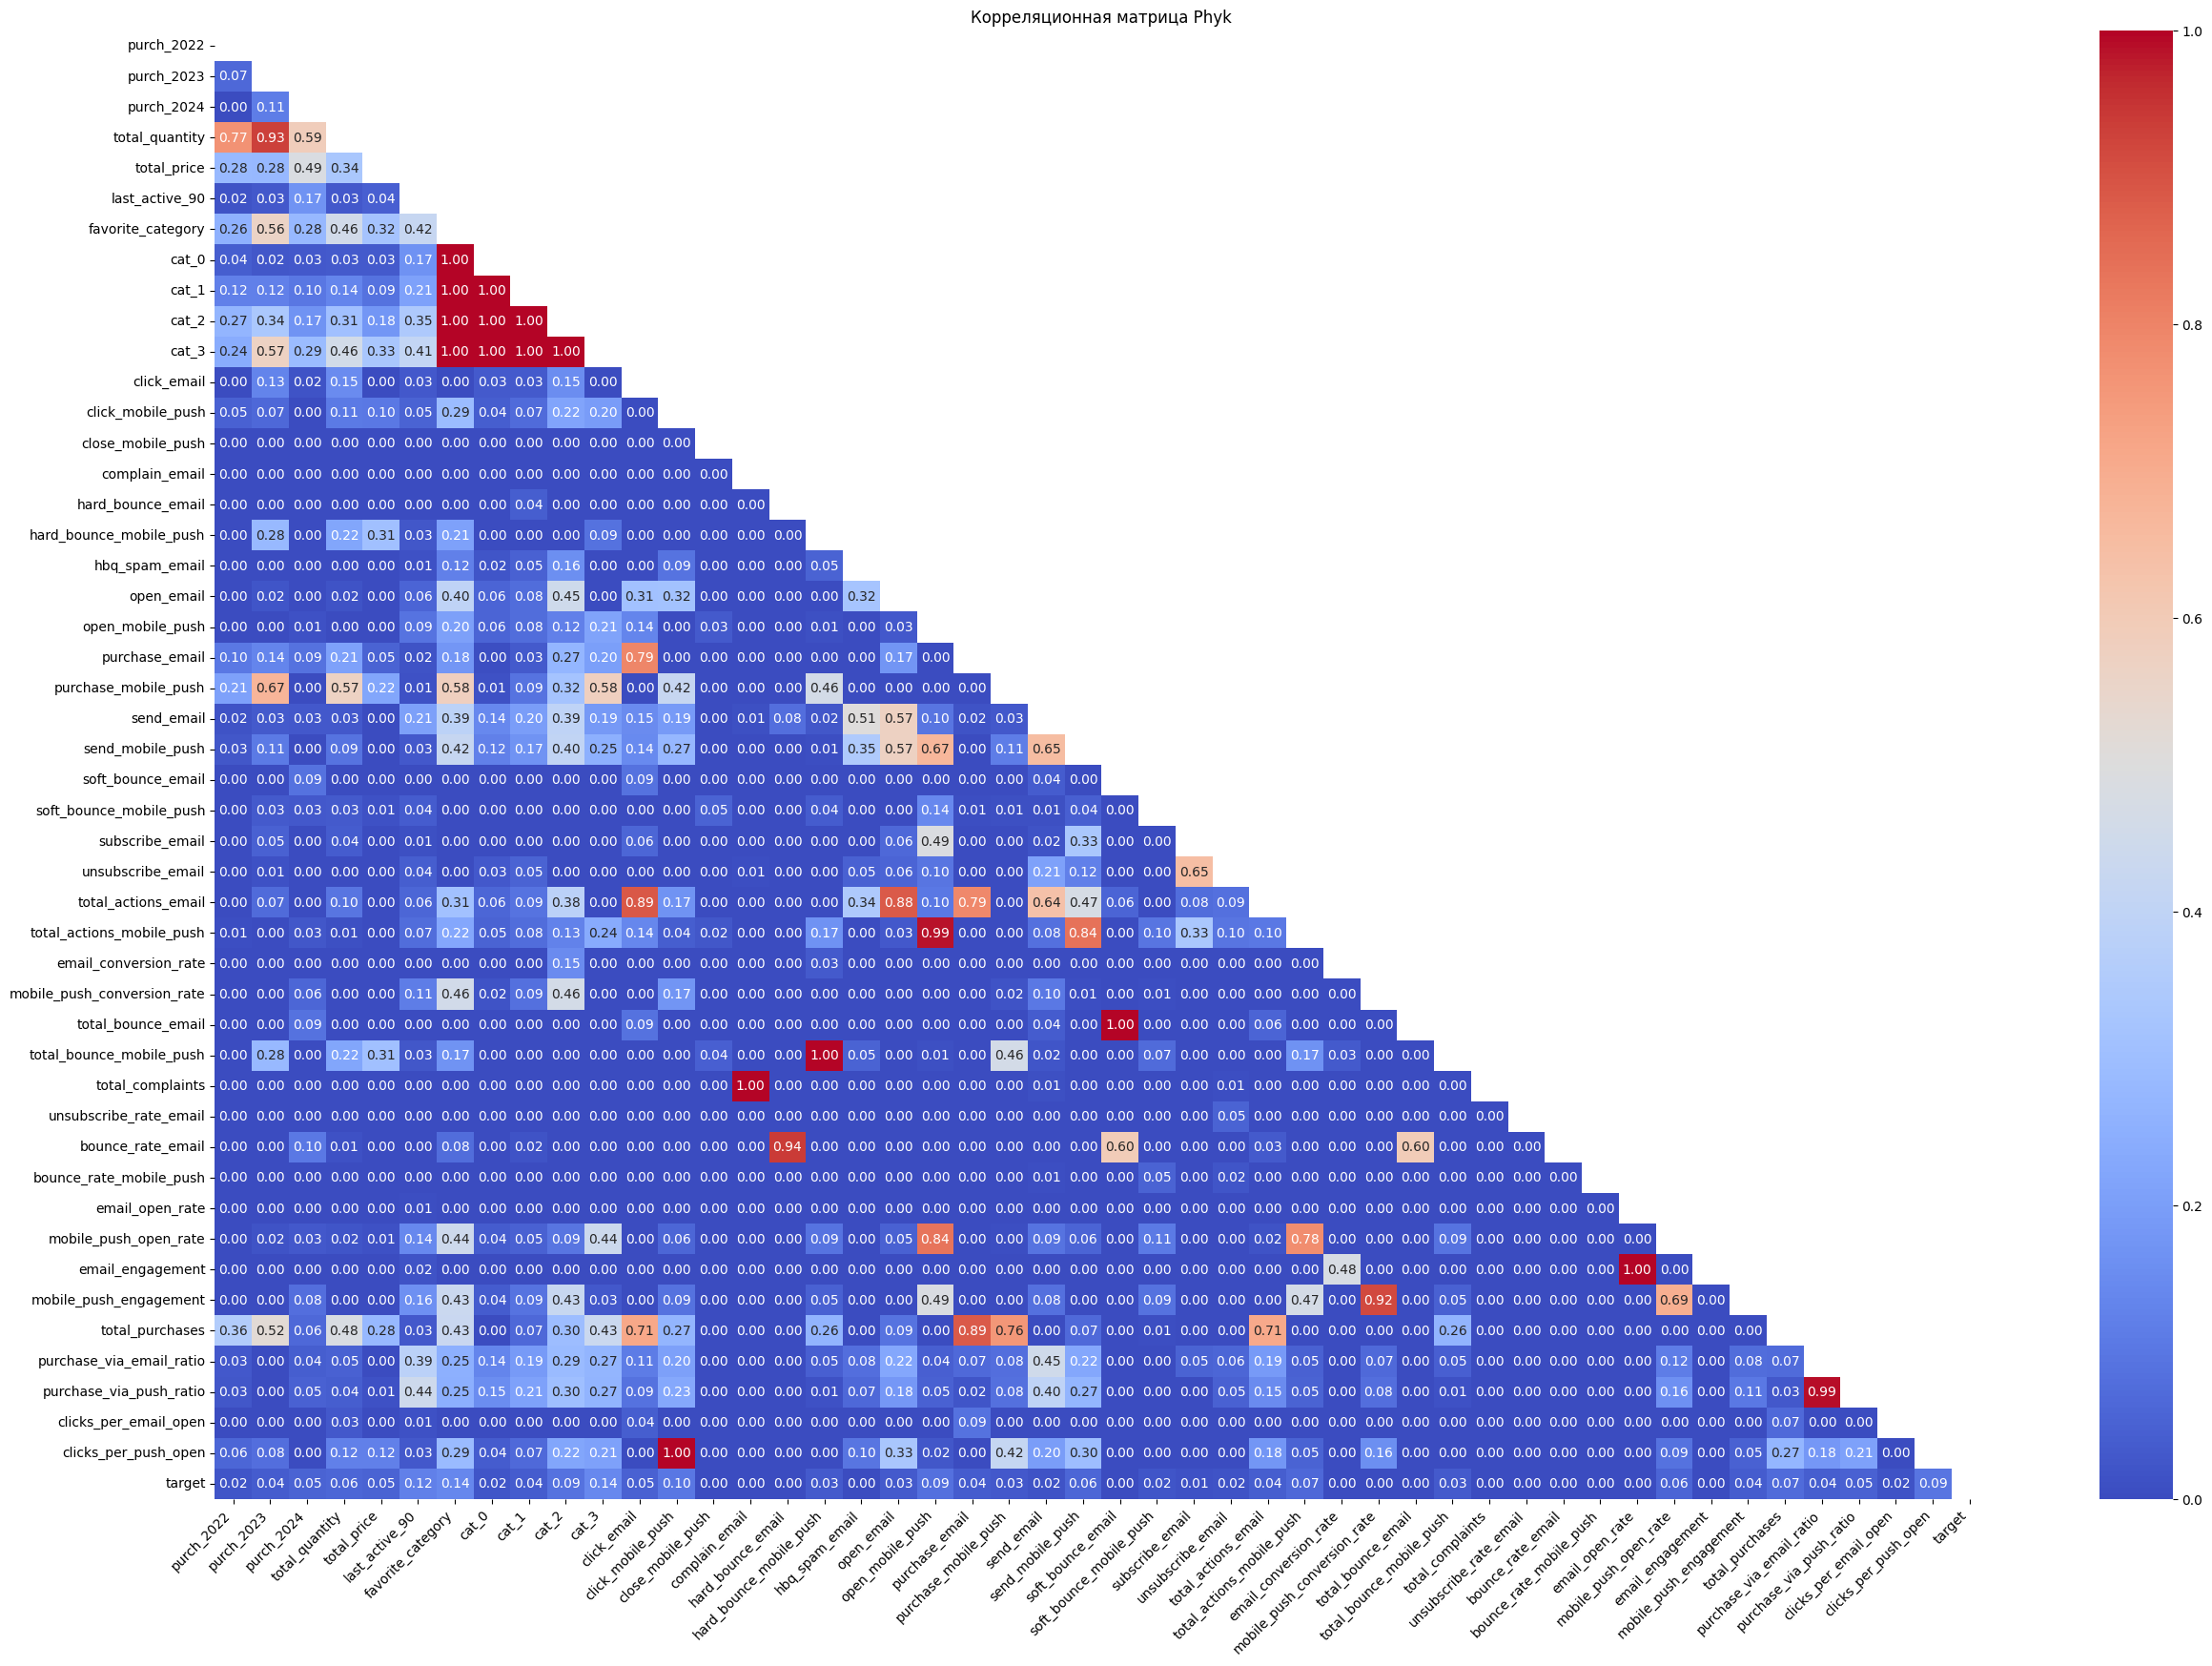

In [68]:
phik_matrix = df_final.drop('client_id', axis=1).phik_matrix(interval_cols=inter)
tri = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(30, 20))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=tri);
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.title("Корреляционная матрица Phyk")
plt.show()

### Spearman

In [100]:
num_col = df_final.drop(['client_id'], axis=1).select_dtypes(include=['int64', 'float64']).columns
num_col

Index(['purch_2022', 'purch_2023', 'purch_2024', 'total_quantity',
       'total_price', 'last_active_90', 'click_email', 'click_mobile_push',
       'close_mobile_push', 'complain_email', 'hard_bounce_email',
       'hard_bounce_mobile_push', 'hbq_spam_email', 'open_email',
       'open_mobile_push', 'purchase_email', 'purchase_mobile_push',
       'send_email', 'send_mobile_push', 'soft_bounce_email',
       'soft_bounce_mobile_push', 'subscribe_email', 'unsubscribe_email',
       'total_actions_email', 'total_actions_mobile_push',
       'email_conversion_rate', 'mobile_push_conversion_rate',
       'total_bounce_email', 'total_bounce_mobile_push', 'total_complaints',
       'unsubscribe_rate_email', 'bounce_rate_email',
       'bounce_rate_mobile_push', 'email_open_rate', 'mobile_push_open_rate',
       'email_engagement', 'mobile_push_engagement', 'total_purchases',
       'purchase_via_email_ratio', 'purchase_via_push_ratio',
       'clicks_per_email_open', 'clicks_per_push_open'

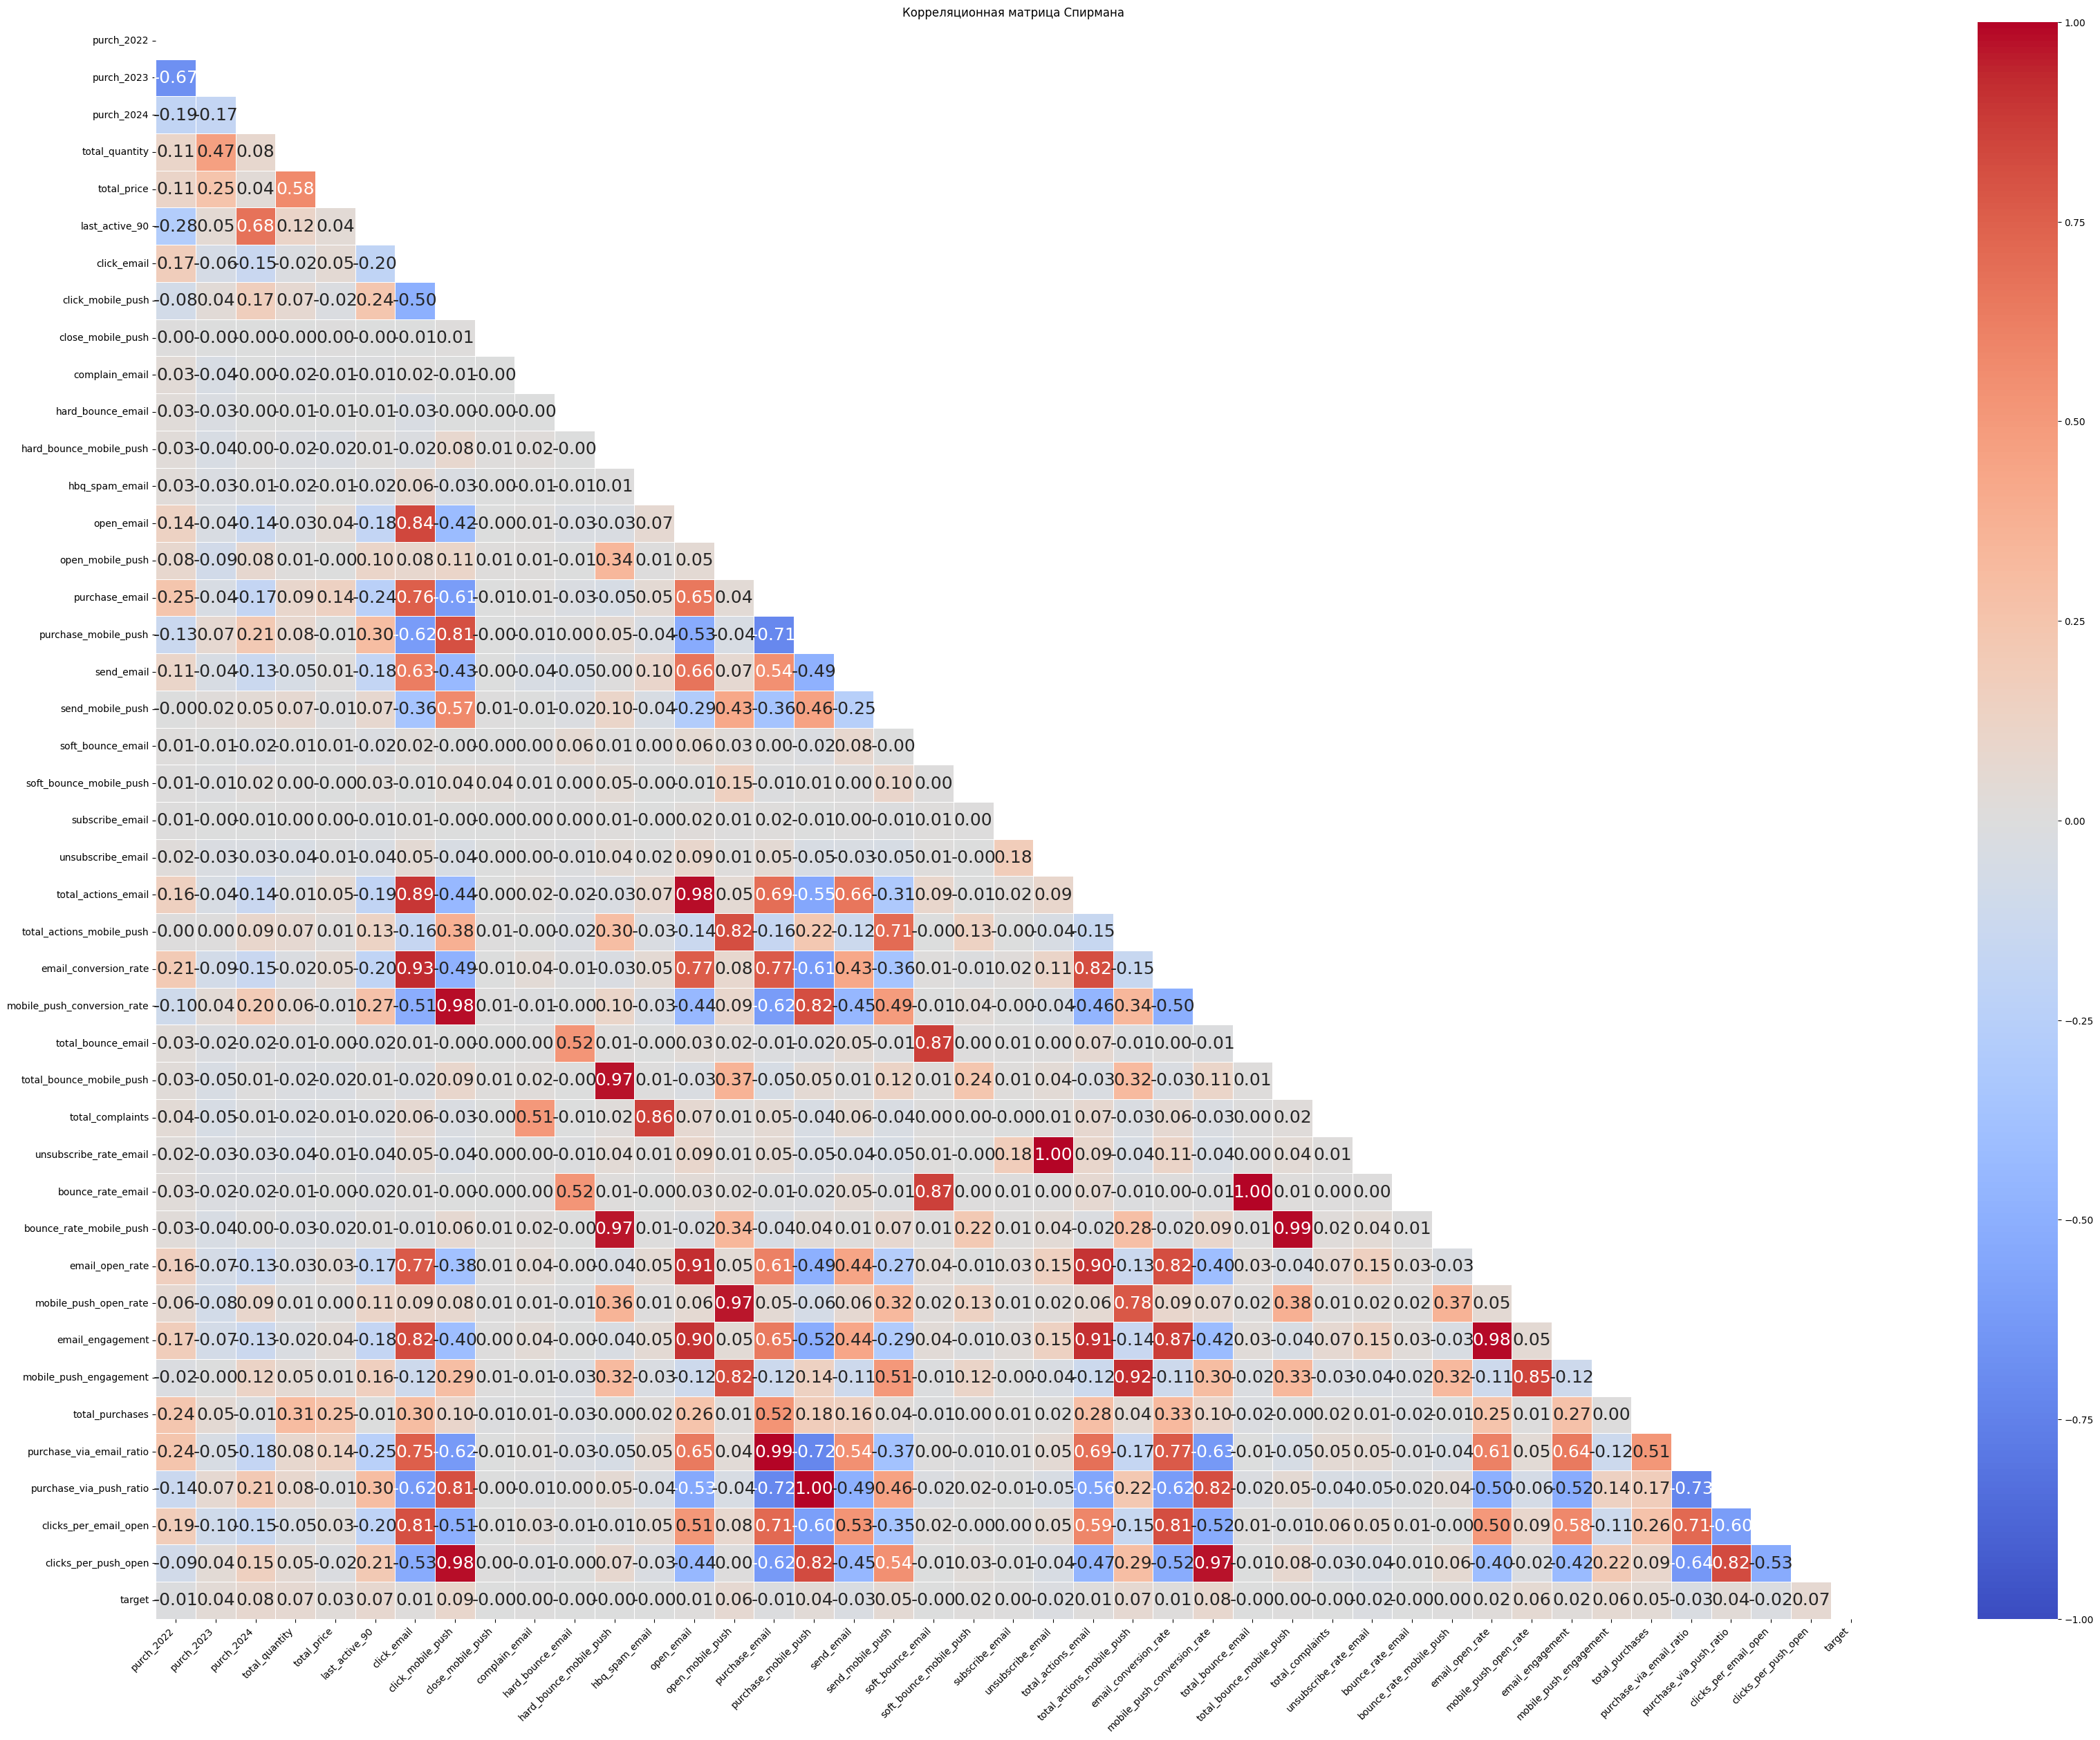

In [104]:
tri = np.triu(np.ones_like(df_final[num_col].corr(), dtype=bool))
plt.figure(figsize=(40, 30))
heatmap = sns.heatmap(
    df_final[num_col].corr('spearman'), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5,  
    vmin=-1, vmax=1, annot_kws={"size": 18}, mask=tri)     
plt.title("Корреляционная матрица Спирмана")
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.show()

### VIF

In [137]:
num_cols = df_final.select_dtypes(include='number').columns

vif_data = pd.DataFrame()
vif_data["feature"] = num_cols

vif_data["VIF"] = [variance_inflation_factor(df_final[num_cols].assign(const=1).values, i) 
                  for i in range(len(num_cols))]

print(vif_data.sort_values('VIF', ascending=False))

                        feature          VIF
35             email_engagement  6153.779189
33              email_open_rate  6017.014680
25        email_conversion_rate    70.370830
7             click_mobile_push     4.402039
4                total_quantity     1.405970
16         purchase_mobile_push     1.224028
39      purchase_via_push_ratio     1.211451
2                    purch_2023     1.180241
0                     client_id     1.178257
38     purchase_via_email_ratio     1.138225
18             send_mobile_push     1.106839
1                    purch_2022     1.102772
37              total_purchases     1.101831
15               purchase_email     1.092061
17                   send_email     1.053593
26  mobile_push_conversion_rate     1.048057
34        mobile_push_open_rate     1.034233
14             open_mobile_push     1.021613
6                   click_email     1.021176
36       mobile_push_engagement     1.013113
3                    purch_2024     1.012027
23        

### Обработка полученных признаков.

Отбросим признаки с нулевой корреляцией к целевой переменной и дублирующие себя по смыслу.

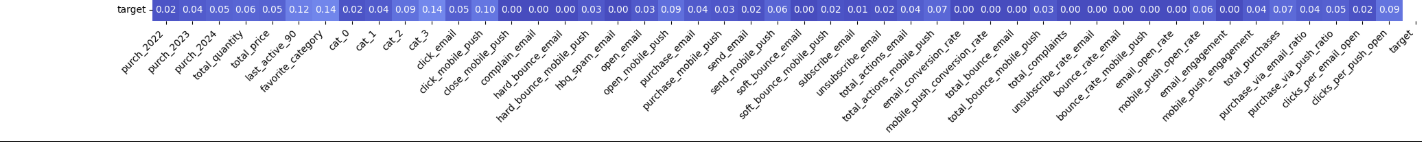

In [105]:
df_final.columns

Index(['client_id', 'purch_2022', 'purch_2023', 'purch_2024', 'total_quantity',
       'total_price', 'last_active_90', 'favorite_category', 'cat_0', 'cat_1',
       'cat_2', 'cat_3', 'click_email', 'click_mobile_push',
       'close_mobile_push', 'complain_email', 'hard_bounce_email',
       'hard_bounce_mobile_push', 'hbq_spam_email', 'open_email',
       'open_mobile_push', 'purchase_email', 'purchase_mobile_push',
       'send_email', 'send_mobile_push', 'soft_bounce_email',
       'soft_bounce_mobile_push', 'subscribe_email', 'unsubscribe_email',
       'total_actions_email', 'total_actions_mobile_push',
       'email_conversion_rate', 'mobile_push_conversion_rate',
       'total_bounce_email', 'total_bounce_mobile_push', 'total_complaints',
       'unsubscribe_rate_email', 'bounce_rate_email',
       'bounce_rate_mobile_push', 'email_open_rate', 'mobile_push_open_rate',
       'email_engagement', 'mobile_push_engagement', 'total_purchases',
       'purchase_via_email_ratio', 'pur

In [184]:
col_todrop = ['close_mobile_push', 'complain_email', 'hard_bounce_email', 'hbq_spam_email', 
              'soft_bounce_email', 'total_bounce_email', 'total_complaints', 
              'unsubscribe_rate_email', 'bounce_rate_email', 'bounce_rate_mobile_push', 'email_engagement', 'email_open_rate', 'email_conversion_rate', 'favorite_category',
              ]

### Вывод

- На основании проведенного корреляционного анализа мы определились со списком признаков , которые будут исключены из обучения моделей.

## Обучение моделей.

In [185]:
X = df_final.drop(['target', 'client_id']+col_todrop, axis=1)
y = df_final['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS, stratify=y) 
                                                
X_train.head(15)

purch_2022  purch_2023  purch_2024  total_quantity  total_price  \
49433           0           0           2               2       3498.0   
41537           3           0           0               3       5397.0   
17439           0           2           0               2       2378.0   
27245           0           2           0               2       3298.0   
18836           1           0           0               1        999.0   
46961           0           1           0               1       2199.0   
49054           0           5           0               5       4396.0   
29936           1           0           0               1       1299.0   
34831           8           0           0               8       4016.0   
12984           1           0           0               1       2199.0   
19681           5           0           0               5       6665.0   
26579           4           0           0               4       6012.0   
45485           2           0           0               2        398.0   
2262            3           0           0               3       5197.0   
22702           7           4           0              11       1334.0   

      last_active_90 cat_0 cat_1 cat_2 cat_3  ...  total_actions_mobile_push  \
49433            1.0     4    28    62   657  ...                       25.0   
41537            0.0     2    18   344   445  ...                        1.0   
17439            0.0  5562  5631  5608   561  ...                        0.0   
27245            0.0     2    18   258   441  ...                        0.0   
18836            0.0  5562  5630  5607   555  ...                        0.0   
46961            0.0  5562  5630  5592   676  ...                       10.0   
49054            1.0     4    28   218   652  ...                      123.0   
29936            0.0     4    28   146   548  ...                       77.0   
34831            0.0     4    31   324   466  ...                        1.0   
12984            0.0     4    31   326   505  ...                       36.0   
19681            0.0     2    18   258  1195  ...                        0.0   
26579            0.0     4    28    62   657  ...                      101.0   
45485            0.0  5562  5631  5608   561  ...                      241.0   
2262             0.0     2    18   212   726  ...                        0.0   
22702            0.0  5562  5597  5691   889  ...                      106.0   

       mobile_push_conversion_rate  total_bounce_mobile_push  \
49433                     0.058824                       1.0   
41537                     0.000000                       1.0   
17439                     0.000000                       0.0   
27245                     0.000000                       0.0   
18836                     0.000000                       0.0   
46961                     0.063380                       1.0   
49054                     0.090164                       1.0   
29936                     0.011236                       1.0   
34831                     0.000000                       1.0   
12984                     0.014706                       1.0   
19681                     0.000000                       0.0   
26579                     0.000000                       0.0   
45485                     0.057377                       0.0   
2262                      0.000000                       0.0   
22702                     0.000000                       2.0   

       mobile_push_open_rate  mobile_push_engagement  total_purchases  \
49433               0.411765                0.450980              1.0   
41537               0.000000                0.000000              3.0   
17439               0.000000                0.000000              1.0   
27245               0.000000                0.000000              1.0   
18836               0.000000                0.000000              1.0   
46961               0.000000                0.056338              1.0   
49054

In [164]:
X_train.columns

Index(['purch_2022', 'purch_2023', 'purch_2024', 'total_quantity',
       'total_price', 'last_active_90', 'cat_0', 'cat_1', 'cat_2', 'cat_3',
       'click_email', 'click_mobile_push', 'open_email', 'open_mobile_push',
       'purchase_email', 'purchase_mobile_push', 'send_email',
       'send_mobile_push', 'subscribe_email', 'unsubscribe_email',
       'total_actions_email', 'total_actions_mobile_push',
       'mobile_push_conversion_rate', 'mobile_push_open_rate',
       'mobile_push_engagement', 'total_purchases', 'purchase_via_email_ratio',
       'purchase_via_push_ratio', 'clicks_per_email_open',
       'clicks_per_push_open'],
      dtype='object')

In [180]:
num_cols = [
    'purch_2022', 'purch_2023', 'purch_2024', 
    'total_quantity', 'total_price', 
    'click_email', 'click_mobile_push',
    'open_email', 'open_mobile_push', 
    'purchase_email', 'purchase_mobile_push',
    'send_email', 'send_mobile_push',
    'subscribe_email', 'unsubscribe_email',
    'total_actions_email', 'total_actions_mobile_push',
    'mobile_push_conversion_rate',
    'mobile_push_open_rate', 'mobile_push_engagement', 
    'total_purchases',
    'purchase_via_email_ratio', 'purchase_via_push_ratio',
    'clicks_per_email_open', 'clicks_per_push_open',
    'total_bounce_mobile_push', 'hard_bounce_mobile_push', 'soft_bounce_mobile_push']

cat_cols = [
    'last_active_90',
    'cat_0', 'cat_1', 'cat_2', 'cat_3']


In [181]:
# Создадим заглущки , а параметры будем перебирать в models
numeric_transformer = Pipeline([
    ('scaler', 'passthrough'),  
    ('preprocessor', None)      
])

cat_transformer = Pipeline([
    ('encoder', 'passthrough'),  
    ('preprocessor', None)      
])

# big_transformer = Pipeline([
#     ('encoder', 'passthrough'),  
#     ('preprocessor', None) 
# ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', cat_transformer, cat_cols), 
        # ('big', big_transformer, big_cat)
    ],
    remainder='passthrough',
    transformer_weights=None)

In [182]:
models = {
    # Логистическая регрессия
    'LogisticRegression': {
        'model': LogisticRegression(random_state=RS, max_iter=1000),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
            'preprocessor__cat__encoder': [OneHotEncoder(handle_unknown='ignore', drop='first')],
            'regressor__C': [0.01, 0.1, 1.0],
            'regressor__solver': ['lbfgs', 'liblinear']
        }
    },
    
    # K-ближайших соседей
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
            'preprocessor__cat__encoder': [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)],
            'regressor__n_neighbors': [3, 5, 7],
            'regressor__weights': ['uniform', 'distance'],
            'regressor__metric': ['euclidean', 'manhattan']
        }
    },
    
    # Решающее дерево
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=RS),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
            'preprocessor__cat__encoder': [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)],

            'regressor__max_depth': [3, 5, 7, None],
            'regressor__min_samples_split': [2, 5, 10],
            'regressor__criterion': ['gini', 'entropy']
        }
    },
       
    # CatBoost 
    'CatBoost': {
        'model': CatBoostClassifier(random_state=RS, verbose=0),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
            'regressor__iterations': [50, 100],
            'regressor__learning_rate': [0.01, 0.1],
            'regressor__depth': [4, 6]
        }
    },
    
    #LightGBM
    'LightGBM': {
        'model': LGBMClassifier(random_state=RS, is_unbalance=True, verbose=-1),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
            # 'preprocessor__cat__encoder': [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)],
            'regressor__n_estimators': [50, 100],
            'regressor__learning_rate': [0.01, 0.1],
            'regressor__max_depth': [3, 5],
            'regressor__num_leaves': [15, 31]
        }
    }
}

In [ ]:
# X_numeric = X_train.select_dtypes(include=['int64', 'float64'])
# adasyn = ADASYN(random_state=42)
# X_resampled, y_resampled = adasyn.fit_resample(X_numeric, y_train)

# print(f"До балансировки: {y_train.sum()} примеров миноритарного класса")
# print(f"После ADASYN: {y_resampled.sum()} примеров")

До балансировки: 769 примеров миноритарного класса
После ADASYN: 39285 примеров


In [198]:
%%time
# KNN выдавал предупреждение разных версий
warnings.filterwarnings("ignore", category=FutureWarning) 
results = {}
for name, config in models.items():

    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])
    
    # Перебор по GridSearch
    grid = GridSearchCV(
        pipeline,
        config['params'],
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    # grid.fit(X_resampled, y_resampled)
    grid.fit(X_train, y_train)
    
    results[name] = {
        'best_model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'best_score': grid.best_score_,
        'mean_fit_time': grid.cv_results_['mean_fit_time'].mean(), 
        'mean_score_time': grid.cv_results_['mean_score_time'].mean() 
         }
    
    print(f"{name} completed. Best Score: {grid.best_score_:.4f}")
for name, res in results.items():
    print(f"{name}:")
    print(f"Test Score: {res['best_score']:.4f}\n")
    print(f"Best Params: {res['best_params']}\n")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
LogisticRegression completed. Best Score: 0.7489
Fitting 5 folds for each of 36 candidates, totalling 180 fits
KNN completed. Best Score: 0.5724
Fitting 5 folds for each of 72 candidates, totalling 360 fits
DecisionTree completed. Best Score: 0.7705
Fitting 5 folds for each of 24 candidates, totalling 120 fits
CatBoost completed. Best Score: 0.8075
Fitting 5 folds for each of 48 candidates, totalling 240 fits
LightGBM completed. Best Score: 0.8081
LogisticRegression:
Test Score: 0.7489

Best Params: {'preprocessor__cat__encoder': OneHotEncoder(drop='first', handle_unknown='ignore'), 'preprocessor__num__scaler': StandardScaler(), 'regressor__C': 0.1, 'regressor__solver': 'lbfgs'}

KNN:
Test Score: 0.5724

Best Params: {'preprocessor__cat__encoder': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__num__scaler': RobustScaler(), 'regressor__metric': 'manhattan', 'regressor__n_neighbors': 7, 're

### Проверка на тестовой выборке

In [187]:
best_model = results['LightGBM']['best_model']
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('preprocessor',
                                                                   None)]),
                                                  ['purch_2022', 'purch_2023',
                                                   'purch_2024',
                                                   'total_quantity',
                                                   'total_price', 'click_email',
                                                   'click_mobile_push',
                                                   'open_email',
                                                   'open_mobile_push',
                                                   'purchase_email',
                                                   'purchase_mobile_push',
                                                   'send_email'...
                                                   'clicks_per_push_open',
                                                   'total_bounce_mobile_push',
                                                   'hard_bounce_mobile_push',
                                                   'soft_bounce_mobile_push']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   'passthrough'),
                                                                  ('preprocessor',
                                                                   None)]),
                                                  ['last_active_90', 'cat_0',
                                                   'cat_1', 'cat_2',
                                                   'cat_3'])])),
                ('regressor',
                 LGBMClassifier(is_unbalance=True, learning_rate=0.01,
                                max_depth=5, num_leaves=15, random_state=42,
                                verbose=-1))])

In [188]:
y_pred = best_model.predict_proba(X_test)[:,1]

C:\Users\para\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [189]:
print(f'Метрика roc_auc на тестовой выборке : {roc_auc_score(y_test, y_pred)}')

Метрика roc_auc на тестовой выборке : 0.8145896187018478


### Важность признаков.

In [190]:
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

importances = best_model.named_steps['regressor'].feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feature_importance_df

feature  importance
12             num__send_mobile_push         104
32                        cat__cat_3          95
15          num__total_actions_email          85
16    num__total_actions_mobile_push          83
11                   num__send_email          81
23        num__clicks_per_email_open          77
6             num__click_mobile_push          66
1                    num__purch_2023          65
7                    num__open_email          61
17  num__mobile_push_conversion_rate          61
3                num__total_quantity          60
5                   num__click_email          56
19       num__mobile_push_engagement          54
18        num__mobile_push_open_rate          50
8              num__open_mobile_push          50
4                   num__total_price          49
28               cat__last_active_90          38
31                        cat__cat_2          35
30                        cat__cat_1          35
2                    num__purch_2024          30
29                        cat__cat_0          30
20              num__total_purchases          27
0                    num__purch_2022          24
14            num__unsubscribe_email          23
24         num__clicks_per_push_open          19
22      num__purchase_via_push_ratio          14
25     num__total_bounce_mobile_push           8
9                num__purchase_email           6
10         num__purchase_mobile_push           6
21     num__purchase_via_email_ratio           5
26      num__hard_bounce_mobile_push           3
27      num__soft_bounce_mobile_push           0
13              num__subscribe_email           0

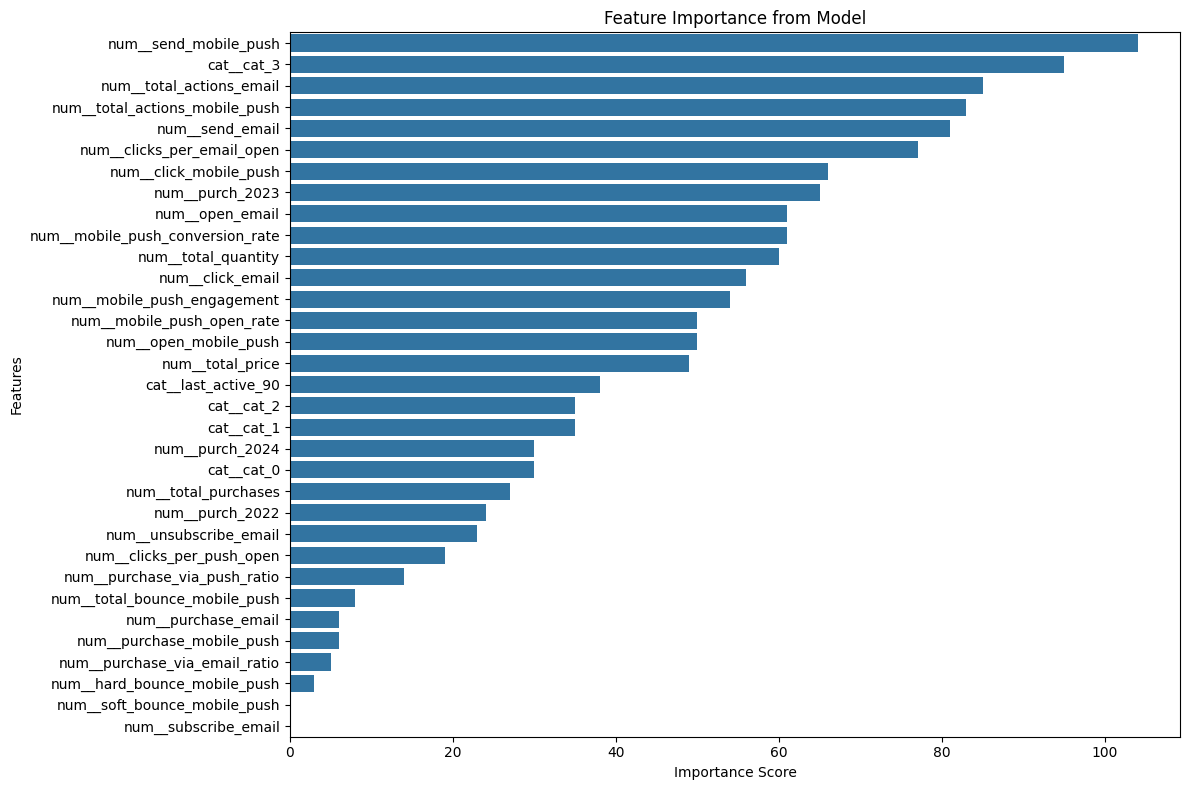

In [192]:

sorted_idx = feature_importance_df['importance'].argsort()

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title("Feature Importance from Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

### Вывод

- Мы построили пайплайн и последовательно протестировали следующие модели : *LogisticRegression, KNN, DecisionTree,  CatBoost, LightGBM* использовав метрику ROC-AUC

- Лидером оказалась модель *LightGBM* c показателем 0.8 на тренировочной и 0.81 на тестовой выборках.
 

- Большее влияние на показатели модели оказали следующие признаки **send_mobile_push cat_3 total_actions_email total_actions_mobile_push send_email clicks_per_email_open**

## Вывод по исследованию.

На входе к нам поступило три датасета  **apparel-messages.csv**,  **apparel-purchases.csv** , **target.csv** содержащие логированную информацию о покупателях интернет магазина. Перед нами стояла задача на основе имеющейся информации создать подходящие для обучения признаки и непосредственно обучить на них модели МО , вот что нам удалось проделать :

- Мы загрузили полученные данные и провели первичное ознакомление. По результатам которого мы не обнаружили явных дефектов в данных , а так же нам удалось определить объединяющий фактор в виде столбца *client_id*
по которому мы будем в дальнейшем вести нашу работу.

- На этапе предобработки данных нам удалось , повысить качество данных , удалив дубликаты из датасета df_mess.

- В процессе создания признаков для обучения мы использовали агрегацию по *client_id*. С последующим объединением и созданием единого набора данных *df_final*. По итогу нами было создано 47 новых признаков.

- В процессе корреляционного анализа мы сократили количество признаков до 33.

- На этапе обучения мы перешли к построению и запуску пайплайна с ходе которого мы провели тестирование нескольких моделей для сравнения методами крос-валидвации. Мы протестировали несколько моделей таких как **LogisticRegression, KNN , DecisionTree, CatBoost, LightGBM** с использованием метрики ROC-AUC , в ходе сравнительного анализа удалось достичь следующих результатов : **LogisticRegression completed. Best Score: 0.7489** **KNN completed. Best Score: 0.5724**  **DecisionTree completed. Best Score: 0.7705**  **CatBoost completed. Best Score: 0.8075** **LightGBM completed. Best Score: 0.8081**

- Лучшей моделью оказалась модель градиентного бустинга LGBM , после проверки на тестовой выборке метрика ROC-AUC остановилась на значении **0.81**